In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import logging
import os
import warnings

import torch
from torch.utils.data import Dataset, DataLoader

try:
    os.chdir("/home/qian.hu/neuron_process_waveform/npf_GWwaveform")
except:
    os.chdir("/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 10
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)
import h5py
#10:2:1=train:test:valid

import scipy
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize_1d
from utils.ntbks_helpers import get_all_gp_datasets
from npf.utils.helpers import rescale_range

from gw.utils import gwutils

import bilby
import time

In [2]:
torch.cuda.is_available()

False

In [2]:
root_dir = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/data/'
root_dir = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/data/'

h5filename = root_dir + 'gw_fd_8D_q25a8M40_2N10k_IMREOB_P.h5'

Ngw = 5000 #gwutils.get_gwfdh5_nsample(h5filename)

Ntrain = int(Ngw*0.7)
Ntest = int(Ngw*0.15)
Nvalid = Ngw - Ntrain - Ntest

output_dir = "/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/run0211/"
output_dir = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0211/"
output_dir = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0215/"
output_dir = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0215_2/"
output_dir = "/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/run0220/"
try:
    train_index = np.int64(np.loadtxt(f'{output_dir}trainindex.txt'))
    test_index = np.int64(np.loadtxt(f'{output_dir}testindex.txt'))
    valid_index = np.int64(np.loadtxt(f'{output_dir}validindex.txt'))
except:
    print("Precomputed indcies not found. Regenerating and saving")
    random_index = np.random.permutation(Ngw)
    train_index = random_index[:Ntrain]
    test_index = random_index[Ntrain:Ntrain+Ntest]
    valid_index = random_index[-Nvalid:]

    #np.savetxt(f'{output_dir}trainindex.txt', train_index)
    #np.savetxt(f'{output_dir}testindex.txt', test_index)
    #np.savetxt(f'{output_dir}validindex.txt', valid_index)

#gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index)
#gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index)
#gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index)


# Plus real

In [3]:

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}
'''
for mode in ['plus', 'cross']:
    for part in ['real', 'imag']:
        train_label = f'{mode}_{part}'
        print(f"Loading {train_label}...")
        gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index, mode=mode, part=part)
        gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index, mode=mode, part=part)
        gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index, mode=mode, part=part)
        
        gw_datasets[train_label] = gw_dataset
        gw_test_datasets[train_label] = gw_test_dataset
        gw_valid_datasets[train_label] = gw_valid_dataset
'''

mode = 'plus'
part = 'real'
train_label = f'{mode}_{part}'
gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index, mode=mode, part=part)
gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index, mode=mode, part=part)
gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index, mode=mode, part=part)

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [4]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.0, b=0.3), targets_getter=get_all_indcs, #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [5]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [6]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    is_continue_train=False,
    criterion=CNPFLoss,
    chckpnt_dirname=output_dir,
    device="cpu",
    lr=5e-5,
    decay_lr=10,
    seed=123,
    batch_size=4,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)




--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 92 | train loss: 5053.7091 | valid loss: 7100.5058 | test log likelihood: -8287.5488


In [7]:
model_pv2v4p = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

In [8]:
gw_test_dataset.waveform_models

array(['IMRPhenomPv2', 'SEOBNRv4P'], dtype='<U12')

In [158]:
#look_approx = 'IMRPhenomPv2'
look_index = 8
chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2')
x_test_eob, y_test_eob = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P')

len_data = len(x_test_imr)
context_fraction = 0.005
len_context = int(len_data*context_fraction)

# random context
#context_index = np.sort( np.random.permutation(len_data)[:len_context] )

# uniform sparse context
context_index = np.arange(0,len_data,int(1/context_fraction))

#context_index = context_index[:len_context//2]
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
y_test_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
y_test_target_eob = y_test_eob[target_index]


x_test_context_mix, y_test_context_mix = gw_test_dataset[look_index]
x_test_target_mix, y_test_target_mix = gw_test_dataset[look_index]

context_index = np.sort(np.append(context_index, context_index+len_data))
target_index = np.sort(np.append(target_index, target_index+len_data))
x_test_context_mix = x_test_context_mix[context_index]
y_test_context_mix = y_test_context_mix[context_index]
x_test_target_mix = x_test_target_mix[target_index]
y_test_target_mix = y_test_target_mix[target_index]

###
#y_test_context_imr = torch.zeros_like(y_test_context_imr)
#y_test_context_eob = torch.zeros_like(y_test_context_eob)
#y_test_context_mix = torch.zeros_like(y_test_context_mix)

In [159]:
len_data

14964

In [160]:
x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2', rescalex=False)
x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

x_test_target_eob_unsc, y_test_target_eob_unsc = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P', rescalex=False)
x_test_target_eob_unsc = x_test_target_eob_unsc.squeeze().numpy()
y_test_target_eob_unsc = y_test_target_eob_unsc.squeeze().numpy()

In [161]:
nsample = 1
t1 = time.time()
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)
mean_mix, std_mix = gwutils.get_predictions(model_pv2v4p, x_test_context_mix.unsqueeze(0), y_test_context_mix.unsqueeze(0),
                                    x_test_target_mix.unsqueeze(0), nsample)
t2 = time.time()
print(f"time cost: {t2-t1}")

time cost: 1.921328067779541


In [162]:
real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


real_freq_test_eob, real_amp_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [y_test_target_eob_unsc], chirp_mass_look)
real_freq_test_eob, real_mean_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [mean_eob], chirp_mass_look)
real_freq_test_eob, real_std_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [std_eob], chirp_mass_look)

real_freq_test_mix, real_mean_test_mix = gwutils.unscale_scaled_fdwaveforms(np.sort(np.append(x_test_target_imr_unsc,x_test_target_imr_unsc)), [mean_mix], chirp_mass_look)
real_freq_test_mix, real_std_test_mix = gwutils.unscale_scaled_fdwaveforms(np.sort(np.append(x_test_target_imr_unsc,x_test_target_imr_unsc)), [std_mix], chirp_mass_look)

real_amp_test_imr = real_amp_test_imr[0]
real_mean_test_imr = real_mean_test_imr[0]
real_std_test_imr = real_std_test_imr[0]
real_amp_test_eob = real_amp_test_eob[0]
real_mean_test_eob = real_mean_test_eob[0]
real_std_test_eob = real_std_test_eob[0]
real_mean_test_mix = real_mean_test_mix[0]
real_std_test_mix = real_std_test_mix[0]


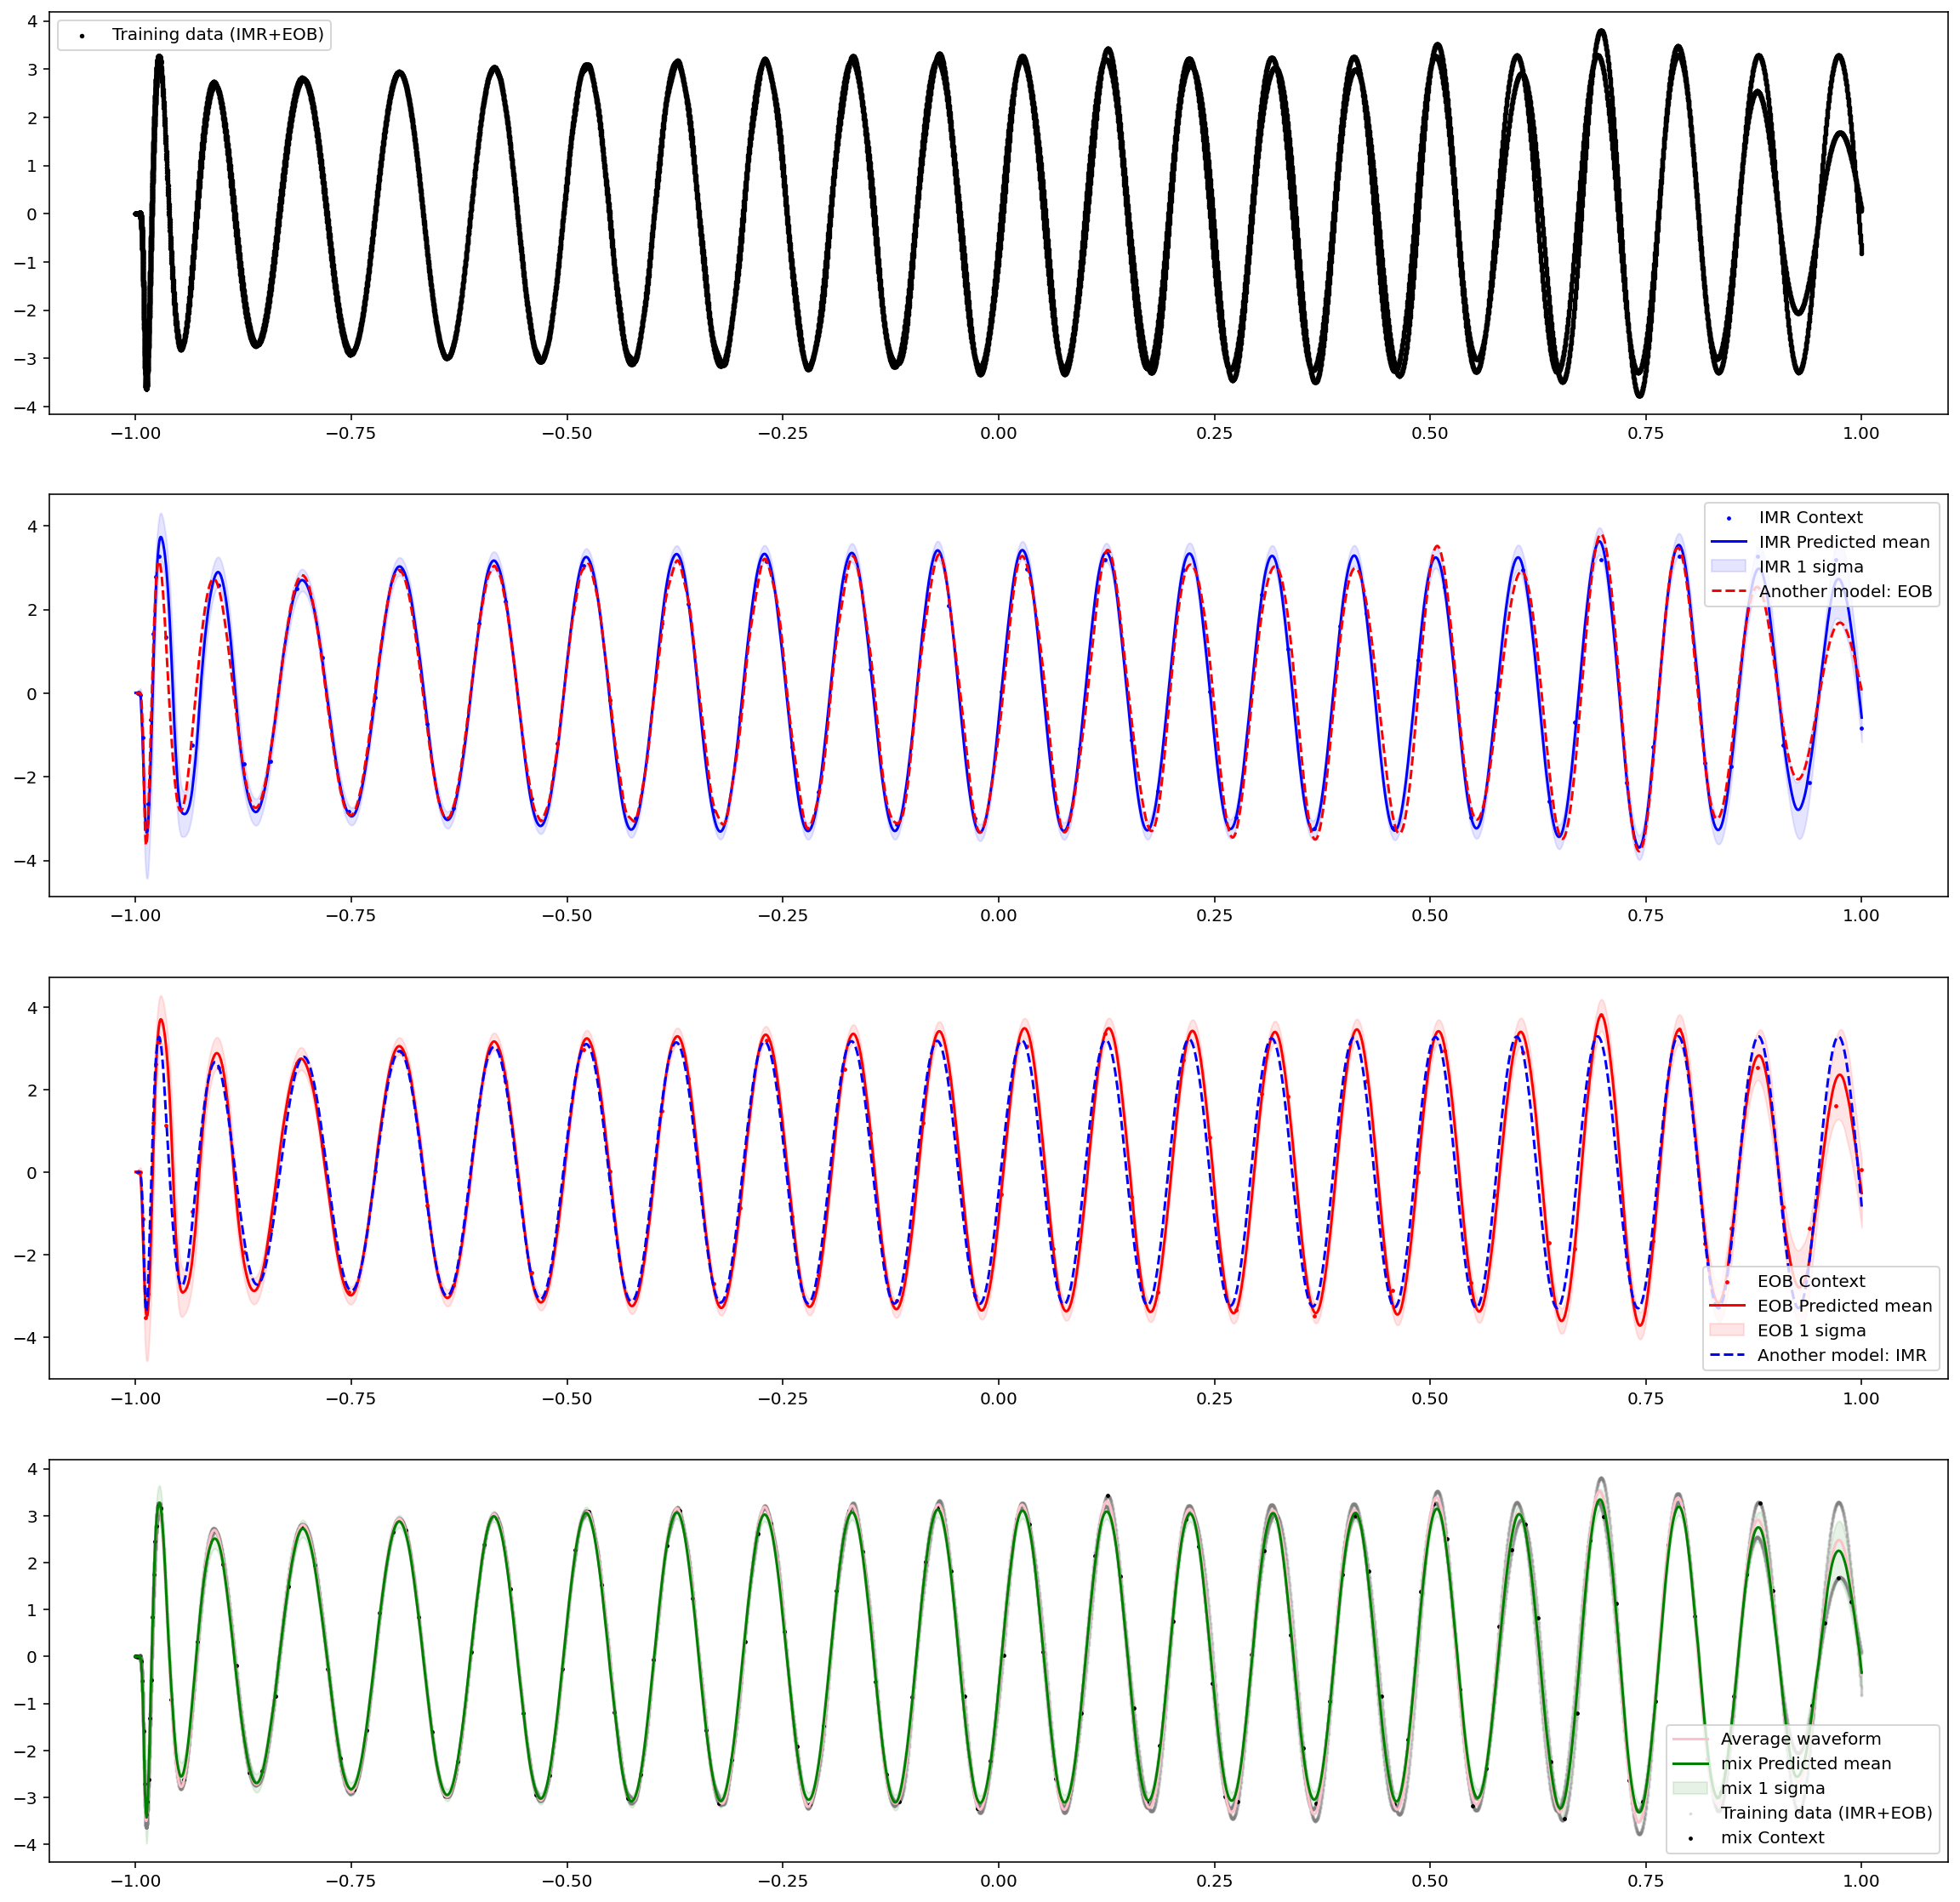

In [163]:
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()

plt.subplot(4,1,2)
plt.scatter(x_test_context_imr, y_test_context_imr, label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr, label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr-std_imr, y2=mean_imr+std_imr, label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob, label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)

plt.subplot(4,1,3)
plt.scatter(x_test_context_eob, y_test_context_eob, label='EOB Context', color='r',s=2)
plt.plot(x_test_target_eob, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze(), y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')
plt.plot(x_test_imr, y_test_imr, label='Another model: IMR', color='b',linestyle='--')
plt.legend()

plt.subplot(4,1,4)
plt.plot(gw_test_dataset[look_index][0][::2], (gw_test_dataset[look_index][1][::2]+gw_test_dataset[look_index][1][1::2])/2, label='Average waveform', color='pink', linestyle='-')
plt.plot(x_test_target_mix, mean_mix, label='mix Predicted mean', color='g',linestyle='-')
plt.fill_between(x=x_test_target_mix.squeeze(), y1=mean_mix-std_mix, y2=mean_mix+std_mix, label='mix 1 sigma', alpha=0.1, color='g')
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1], label='Training data (IMR+EOB)', color='grey',s=1, alpha=0.2)
plt.scatter(x_test_context_mix, y_test_context_mix, label='mix Context', color='k',s=2)

plt.legend()

#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

Text(0, 0.5, 'std')

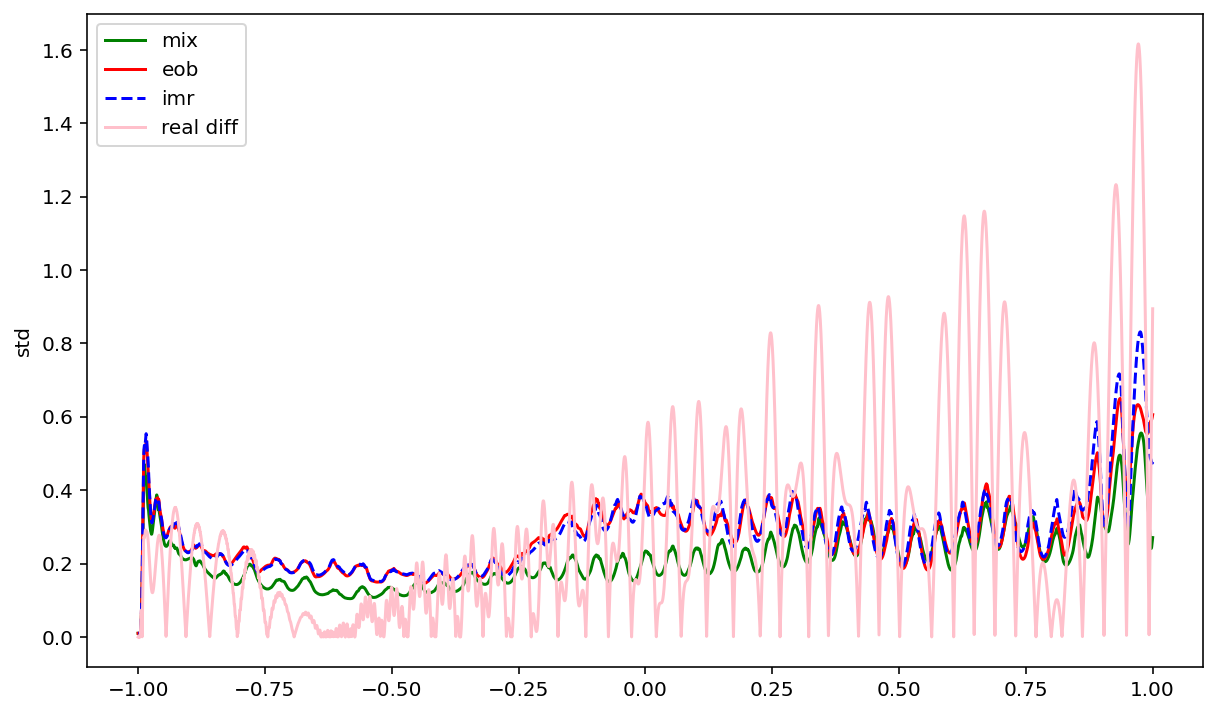

In [127]:
plt.figure(figsize=(10,6))

plt.plot(x_test_target_mix.squeeze(), std_mix, label='mix', color='g')
plt.plot(x_test_target_eob.squeeze(), std_eob, label='eob', color='r')
plt.plot(x_test_target_imr.squeeze(), std_imr, label='imr', color='b',linestyle='--')
plt.plot(x_test_target_mix.squeeze()[::2], abs(gw_test_dataset[look_index][1][::2]-gw_test_dataset[look_index][1][1::2]),
         label='real diff', color='pink')
plt.legend()
plt.ylabel('std')

Text(0, 0.5, 'std')

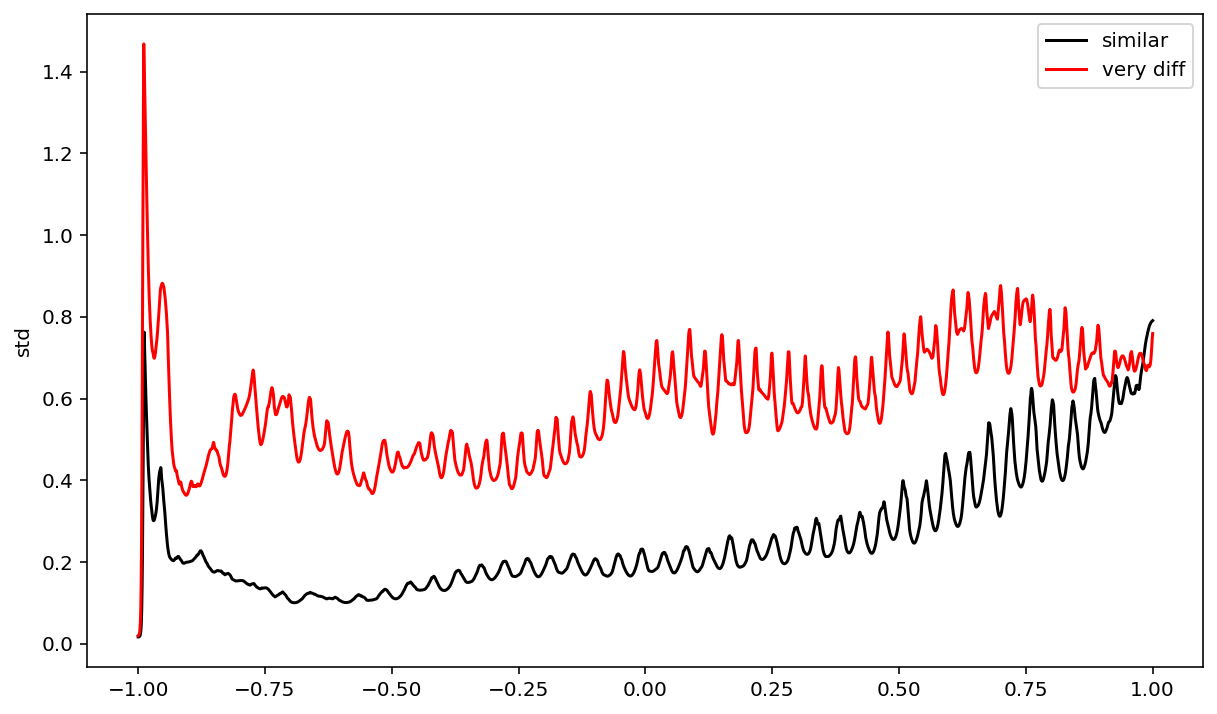

In [115]:
plt.figure(figsize=(10,6))


#temp1 = x_test_target_mix.squeeze()
#temp2 = std_mix
plt.plot(temp1, temp2, label='similar', color='k')
plt.plot(x_test_target_mix.squeeze(), std_mix, label='very diff', color='r')
#plt.plot(x_test_target_eob.squeeze(), std_eob, label='eob', color='r')

plt.legend()
plt.ylabel('std')

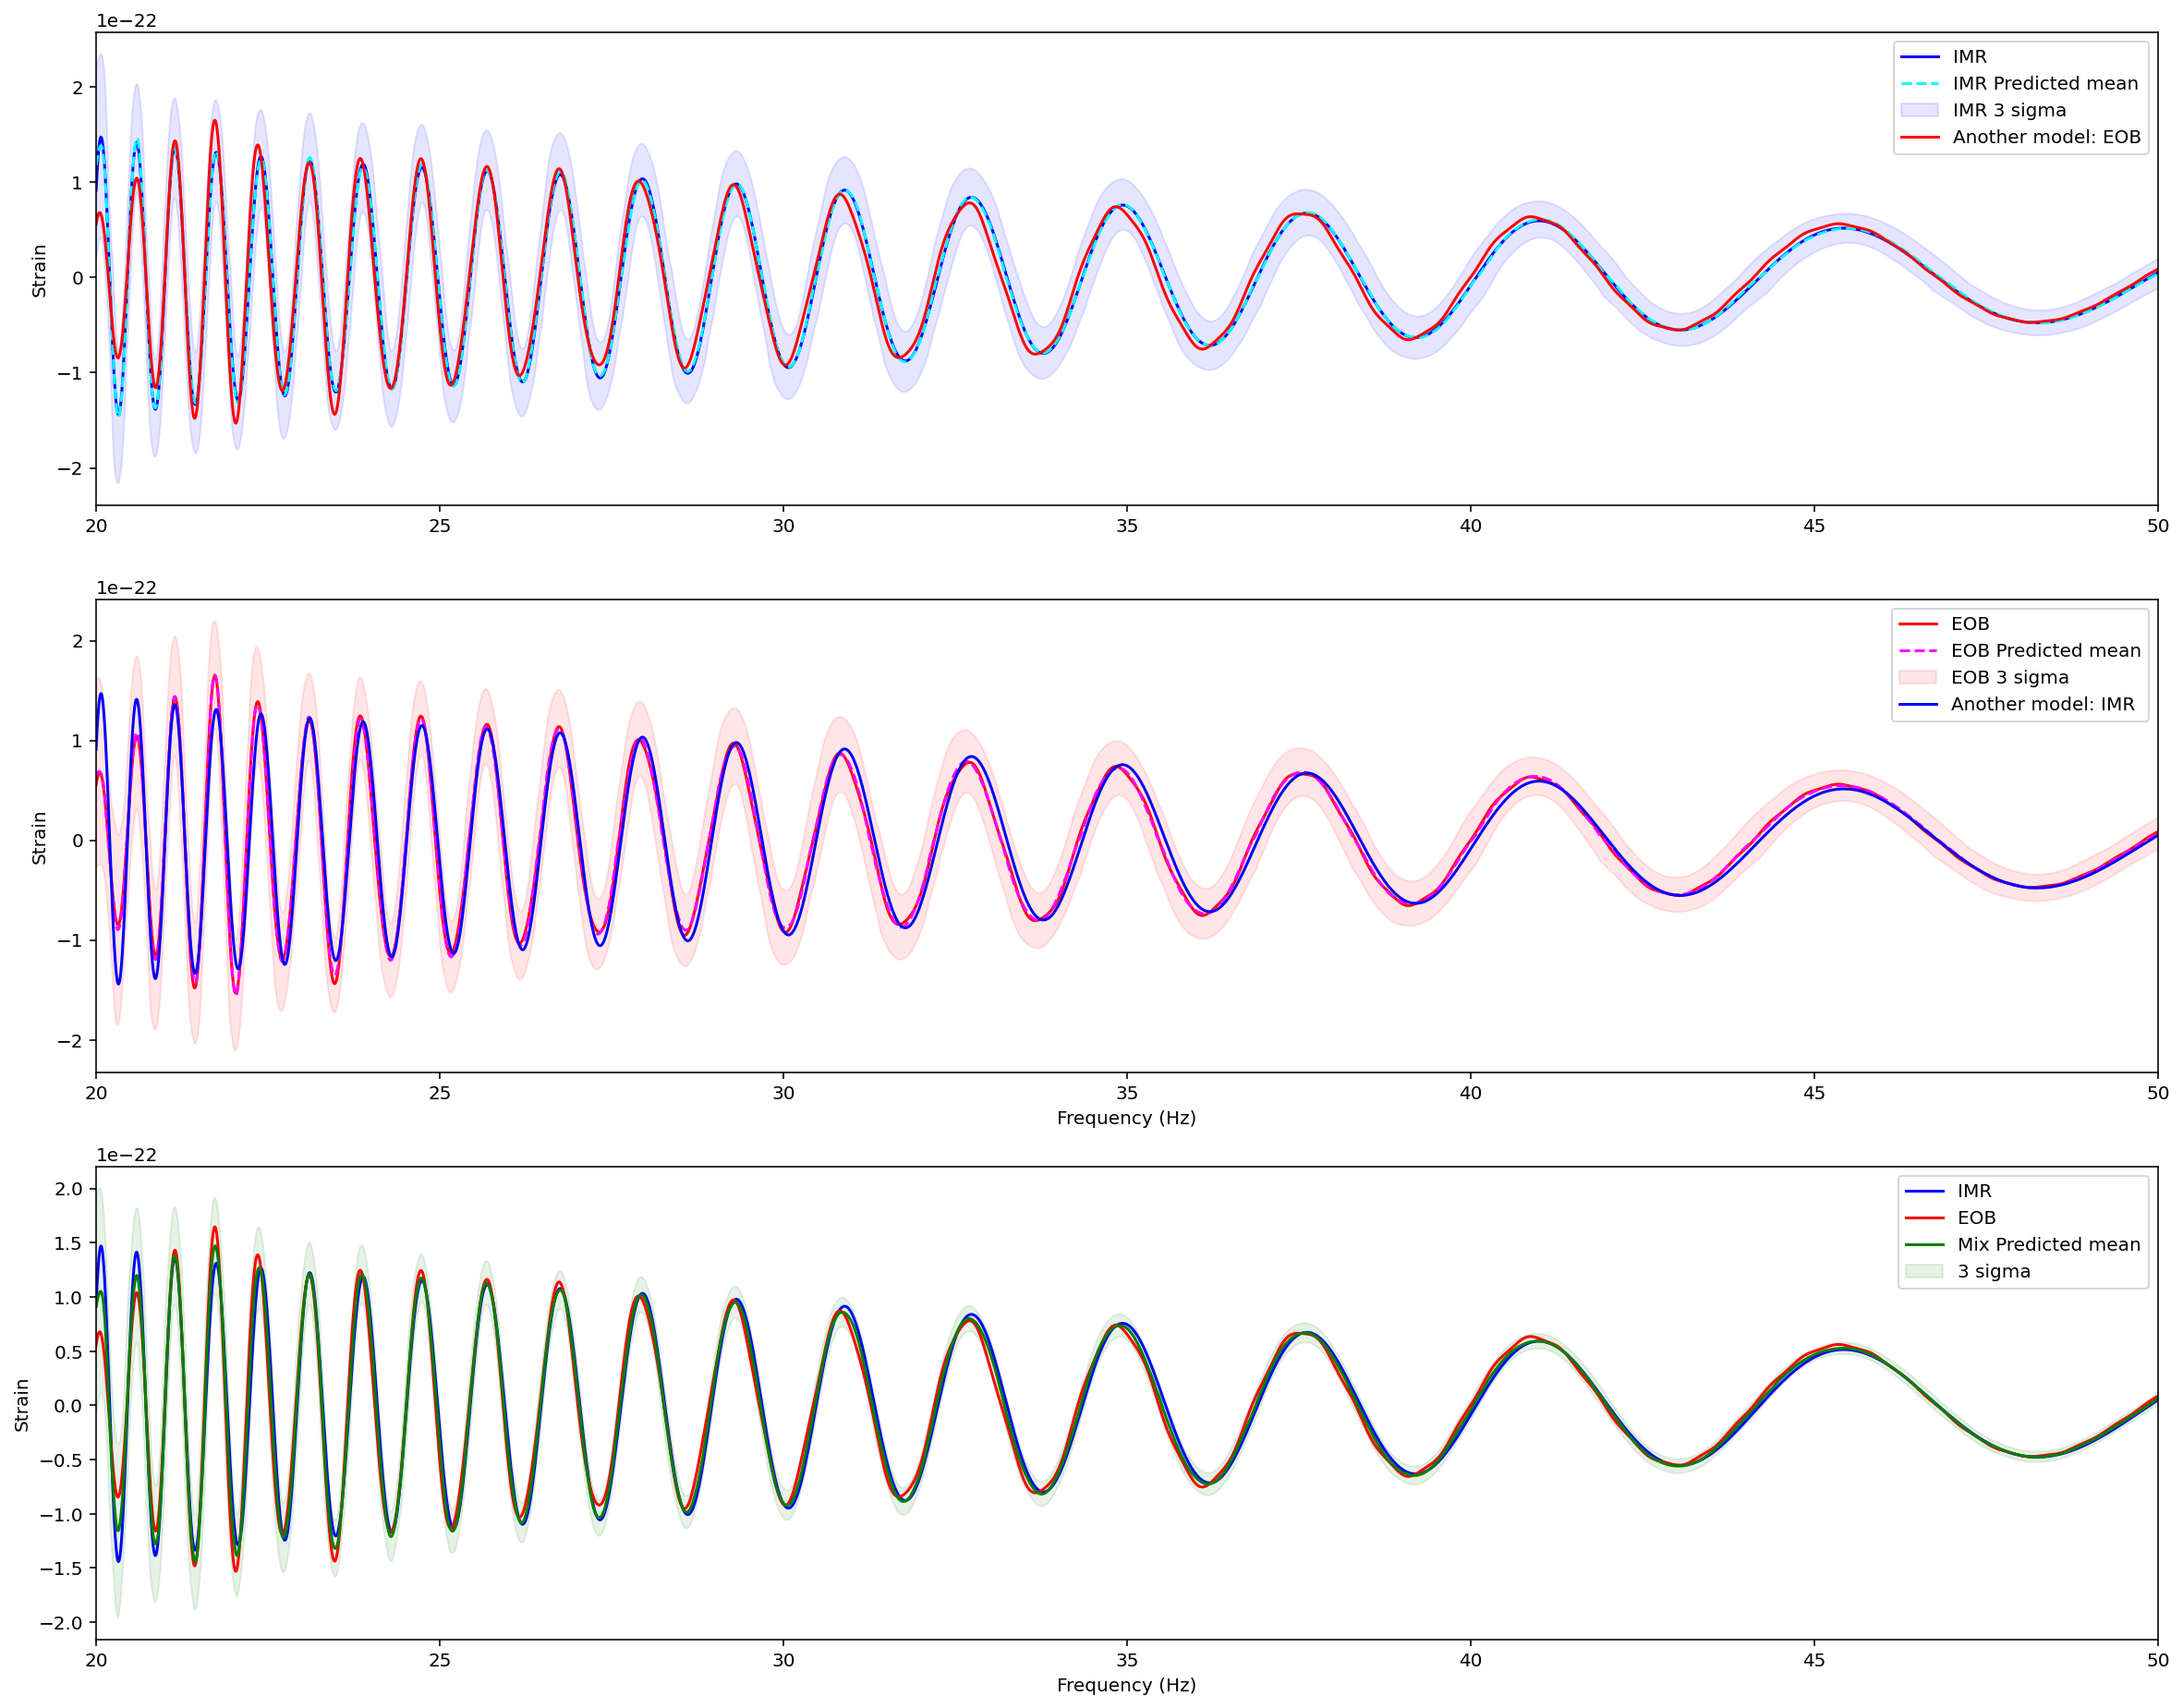

In [72]:
plt.figure(figsize=(20,16))
xlim_low=20
xlim_high=50
nsigma = 3

plt.subplot(3,1,1)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_imr, real_mean_test_imr, label='IMR Predicted mean', color='cyan',linestyle='--')
plt.fill_between(x=real_freq_test_imr, y1=real_mean_test_imr-nsigma*real_std_test_imr, y2=real_mean_test_imr+nsigma*real_std_test_imr,
                 label=f'IMR {nsigma} sigma', alpha=0.1, color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='Another model: EOB', color='r',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.ylabel('Strain')



plt.subplot(3,1,2)
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')
plt.plot(real_freq_test_eob, real_mean_test_eob, label='EOB Predicted mean', color='magenta',linestyle='--')
plt.fill_between(x=real_freq_test_eob, y1=real_mean_test_eob-nsigma*real_std_test_eob, y2=real_mean_test_eob+nsigma*real_std_test_eob,
                 label=f'EOB {nsigma} sigma', alpha=0.1, color='r')
plt.plot(real_freq_test_imr, real_amp_test_imr, label='Another model: IMR', color='b',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')

plt.subplot(3,1,3)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')

plt.plot(real_freq_test_mix,
            real_mean_test_mix, 
            label='Mix Predicted mean', 
            color='g',)
plt.fill_between(x=real_freq_test_mix,  #
                y1=real_mean_test_mix-nsigma*real_std_test_mix, 
                y2=real_mean_test_mix+nsigma*real_std_test_mix,
                label=f'{nsigma} sigma', alpha=0.1, color='g')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')


#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

# Plus imag

In [58]:

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}
'''
for mode in ['plus', 'cross']:
    for part in ['real', 'imag']:
        train_label = f'{mode}_{part}'
        print(f"Loading {train_label}...")
        gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index, mode=mode, part=part)
        gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index, mode=mode, part=part)
        gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index, mode=mode, part=part)
        
        gw_datasets[train_label] = gw_dataset
        gw_test_datasets[train_label] = gw_test_dataset
        gw_valid_datasets[train_label] = gw_valid_dataset
'''

mode = 'plus'
part = 'imag'
train_label = f'{mode}_{part}'
gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index, mode=mode, part=part)
gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index, mode=mode, part=part)
gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index, mode=mode, part=part)

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [59]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.3, b=0.5), targets_getter=GetRandomIndcs(a=0.3, b=0.5), #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [60]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [61]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=True,  # whether to load precomputed model or retrain
    is_continue_train=False,
    criterion=CNPFLoss,
    chckpnt_dirname=output_dir,
    device="cuda",
    lr=5e-5,
    decay_lr=10,
    seed=123,
    batch_size=4,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)




--- Training plus_imag/ConvCNP/run_0 ---



  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1    25445.3970    15577.5585     +  49.1492


      2    28557.0926    11703.5525     +  44.4714


      3    11180.4130    10227.3219     +  44.9767


      4    10049.4884     9682.6481     +  43.9667


      5     9025.1624     9155.0005     +  44.2403


      6     8312.0827     7361.9329     +  43.3892


      7     7714.4071     8074.3499        43.2668


      8     7641.4170     7036.4173     +  44.2403


      9     7667.4205     7091.1370        43.4321


     10     7513.9877     6765.0527     +  45.4191


     11     7284.8342     6810.5860        43.7942


     12     6830.2495     5908.5141     +  45.5260


     13     6549.0483    10299.4879        44.4752


     14     6469.5818     5533.5288     +  43.3562


     15     6834.5545     5977.9483        44.0245


     16     6101.2426     5151.9897     +  43.9462


     17     5708.2551     5984.6434        43.6210


     18     5784.1856     4826.0743     +  45.6230


     19     5582.7627     5937.0034        44.1096


     20     5278.1534     5462.0795        44.4614


     21     5641.5417     4790.1953     +  45.0852


     22     5374.3004     7422.4811        43.1762


     23     4979.4625     9805.6805        44.3190


     24     5235.6228     5845.2847        43.4337


     25     4929.6589     5762.4039        43.5446


     26     4765.8203    48453.1465        44.8324


     27     4833.0636     5092.6006        43.8797


     28     4627.8736     5393.7967        45.1324


     29     4845.1112     8482.5998        45.3716


     30     4807.7653     4610.5110     +  43.7008


     31     4584.4168     4173.8916     +  44.9066


     32     4361.3161     5158.0627        43.6535


     33     4468.3294     4063.2381     +  44.6823


     34     4265.9725     3909.6032     +  44.0972


     35     4237.9091     5185.8793        43.9106


     36     4362.9085     3756.2017     +  45.8620


     37     4173.6572     3721.3109     +  44.8125


     38     4057.0057     5888.3734        45.1272


     39     3990.5658     3469.6076     +  44.3341


     40     3904.6576     5388.6695        43.5038


     41     3820.2803     3448.1272     +  44.6402


     42     3771.2712     4487.0721        43.7731


     43     3725.4311     3614.1022        44.7682


     44     3702.1700     3972.9726        44.8617


     45     3605.0008     3008.3052     +  43.8619


     46     3600.1903     3456.1365        46.2236


     47     3495.1900     3905.7481        43.8906


     48     3473.5758     3222.1326        44.0686


     49     3394.4390     3335.5149        44.6678


     50     3292.8487     3950.0345        43.7856


     51     3209.6448     3557.4820        45.6425


     52     3130.3290     3343.0697        44.9863


     53     2979.5171     3081.8916        44.3916


     54     2985.5077     2580.8485     +  45.9168


     55     2917.1901     3456.1334        46.8415


     56     2821.8843     4216.3679        50.4883


     57     2850.2797     2442.0132     +  49.1871


     58     2789.6979     2657.2062        49.1514


     59     2697.7443     2257.6673     +  50.1991


     60     2675.6487     2938.3648        49.9365


     61     2578.9393     2782.6035        51.5875


     62     2513.4090     2905.7514        50.1426


     63     2501.6448     3707.4228        224.8707


     64     2371.6720     2472.7713        49.9268


     65     2385.3320     3681.8177        50.3516


     66     2281.8154     2186.1622     +  51.3018


     67     2354.6093     2669.6451        51.2611


     68     2212.5645     2646.9536        51.4540


     69     2290.3807     2508.3663        52.6123


     70     2248.2194     3315.4466        51.6409


     71     2123.7567     2150.8045     +  50.2419


     72     2142.4259     5178.2737        49.0884


     73     2101.9138     2990.3403        49.8839


     74     1994.2653     3771.1254        49.6815


     75     1985.7835     1915.8365     +  50.1492


     76     1975.0922     1666.8195     +  50.0479


     77     1927.0499     4151.7963        50.0099


     78     1972.5967     1551.2143     +  52.7132


     79     1899.6175     2582.1731        52.3618


     80     1849.7305     1920.3468        49.9989


     81     1859.9841     1863.5163        49.8734


     82     1843.8950     2147.2222        49.1304


     83     1808.0010     2456.7512        51.1587


     84     1775.3428     2049.2570        49.9511


     85     1650.9978     1995.4910        50.5222


     86     1706.3321     1690.7636        50.6764


     87     1700.4034     1457.7090     +  51.1077


     88     1684.6312     1598.1625        53.2389


     89     1661.5401     1929.8843        50.1360


     90     1591.9205     1651.1354        49.3607


     91     1605.0885     1872.1665        49.9021


     92     1568.6068     2004.0837        49.8405


     93     1643.3344     1525.9380        51.1363


     94     1516.7490     1761.7049        50.4148


     95     1549.6996     1464.1129        61.9967


     96     1499.4002     2565.7494        56.8428


     97     1481.3873     1354.7644     +  53.4238


     98     1416.4925     1595.4635        52.6053


     99     1454.8465     1993.7202        50.3460


    100     1424.0462     1977.7674        50.7064


plus_imag/ConvCNP/run_0 | best epoch: 97 | train loss: 1416.4925 | valid loss: 1354.7644 | test log likelihood: -1920.464


In [62]:
model_pv2v4p = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

In [63]:
gw_test_dataset.waveform_models

array(['IMRPhenomPv2', 'SEOBNRv4P'], dtype='<U12')

In [64]:
#look_approx = 'IMRPhenomPv2'
look_index = 2
chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2')
x_test_eob, y_test_eob = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P')

len_data = len(x_test_imr)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
x_yest_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
x_yest_target_eob = y_test_eob[target_index]


x_test_context_mix, y_test_context_mix = gw_test_dataset[look_index]
x_test_target_mix, y_test_target_mix = gw_test_dataset[look_index]


In [65]:
x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2', rescalex=False)
x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

x_test_target_eob_unsc, y_test_target_eob_unsc = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P', rescalex=False)
x_test_target_eob_unsc = x_test_target_eob_unsc.squeeze().numpy()
y_test_target_eob_unsc = y_test_target_eob_unsc.squeeze().numpy()

In [66]:
nsample = 1
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)
mean_mix, std_mix = gwutils.get_predictions(model_pv2v4p, x_test_context_mix.unsqueeze(0), y_test_context_mix.unsqueeze(0),
                                    x_test_target_mix.unsqueeze(0), nsample)

In [67]:
real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


real_freq_test_eob, real_amp_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [y_test_target_eob_unsc], chirp_mass_look)
real_freq_test_eob, real_mean_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [mean_eob], chirp_mass_look)
real_freq_test_eob, real_std_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [std_eob], chirp_mass_look)

real_freq_test_mix, real_mean_test_mix = gwutils.unscale_scaled_fdwaveforms(np.sort(np.append(x_test_target_imr_unsc,x_test_target_imr_unsc)), [mean_mix], chirp_mass_look)
real_freq_test_mix, real_std_test_mix = gwutils.unscale_scaled_fdwaveforms(np.sort(np.append(x_test_target_imr_unsc,x_test_target_imr_unsc)), [std_mix], chirp_mass_look)

real_amp_test_imr = real_amp_test_imr[0]
real_mean_test_imr = real_mean_test_imr[0]
real_std_test_imr = real_std_test_imr[0]
real_amp_test_eob = real_amp_test_eob[0]
real_mean_test_eob = real_mean_test_eob[0]
real_std_test_eob = real_std_test_eob[0]
real_mean_test_mix = real_mean_test_mix[0]
real_std_test_mix = real_std_test_mix[0]


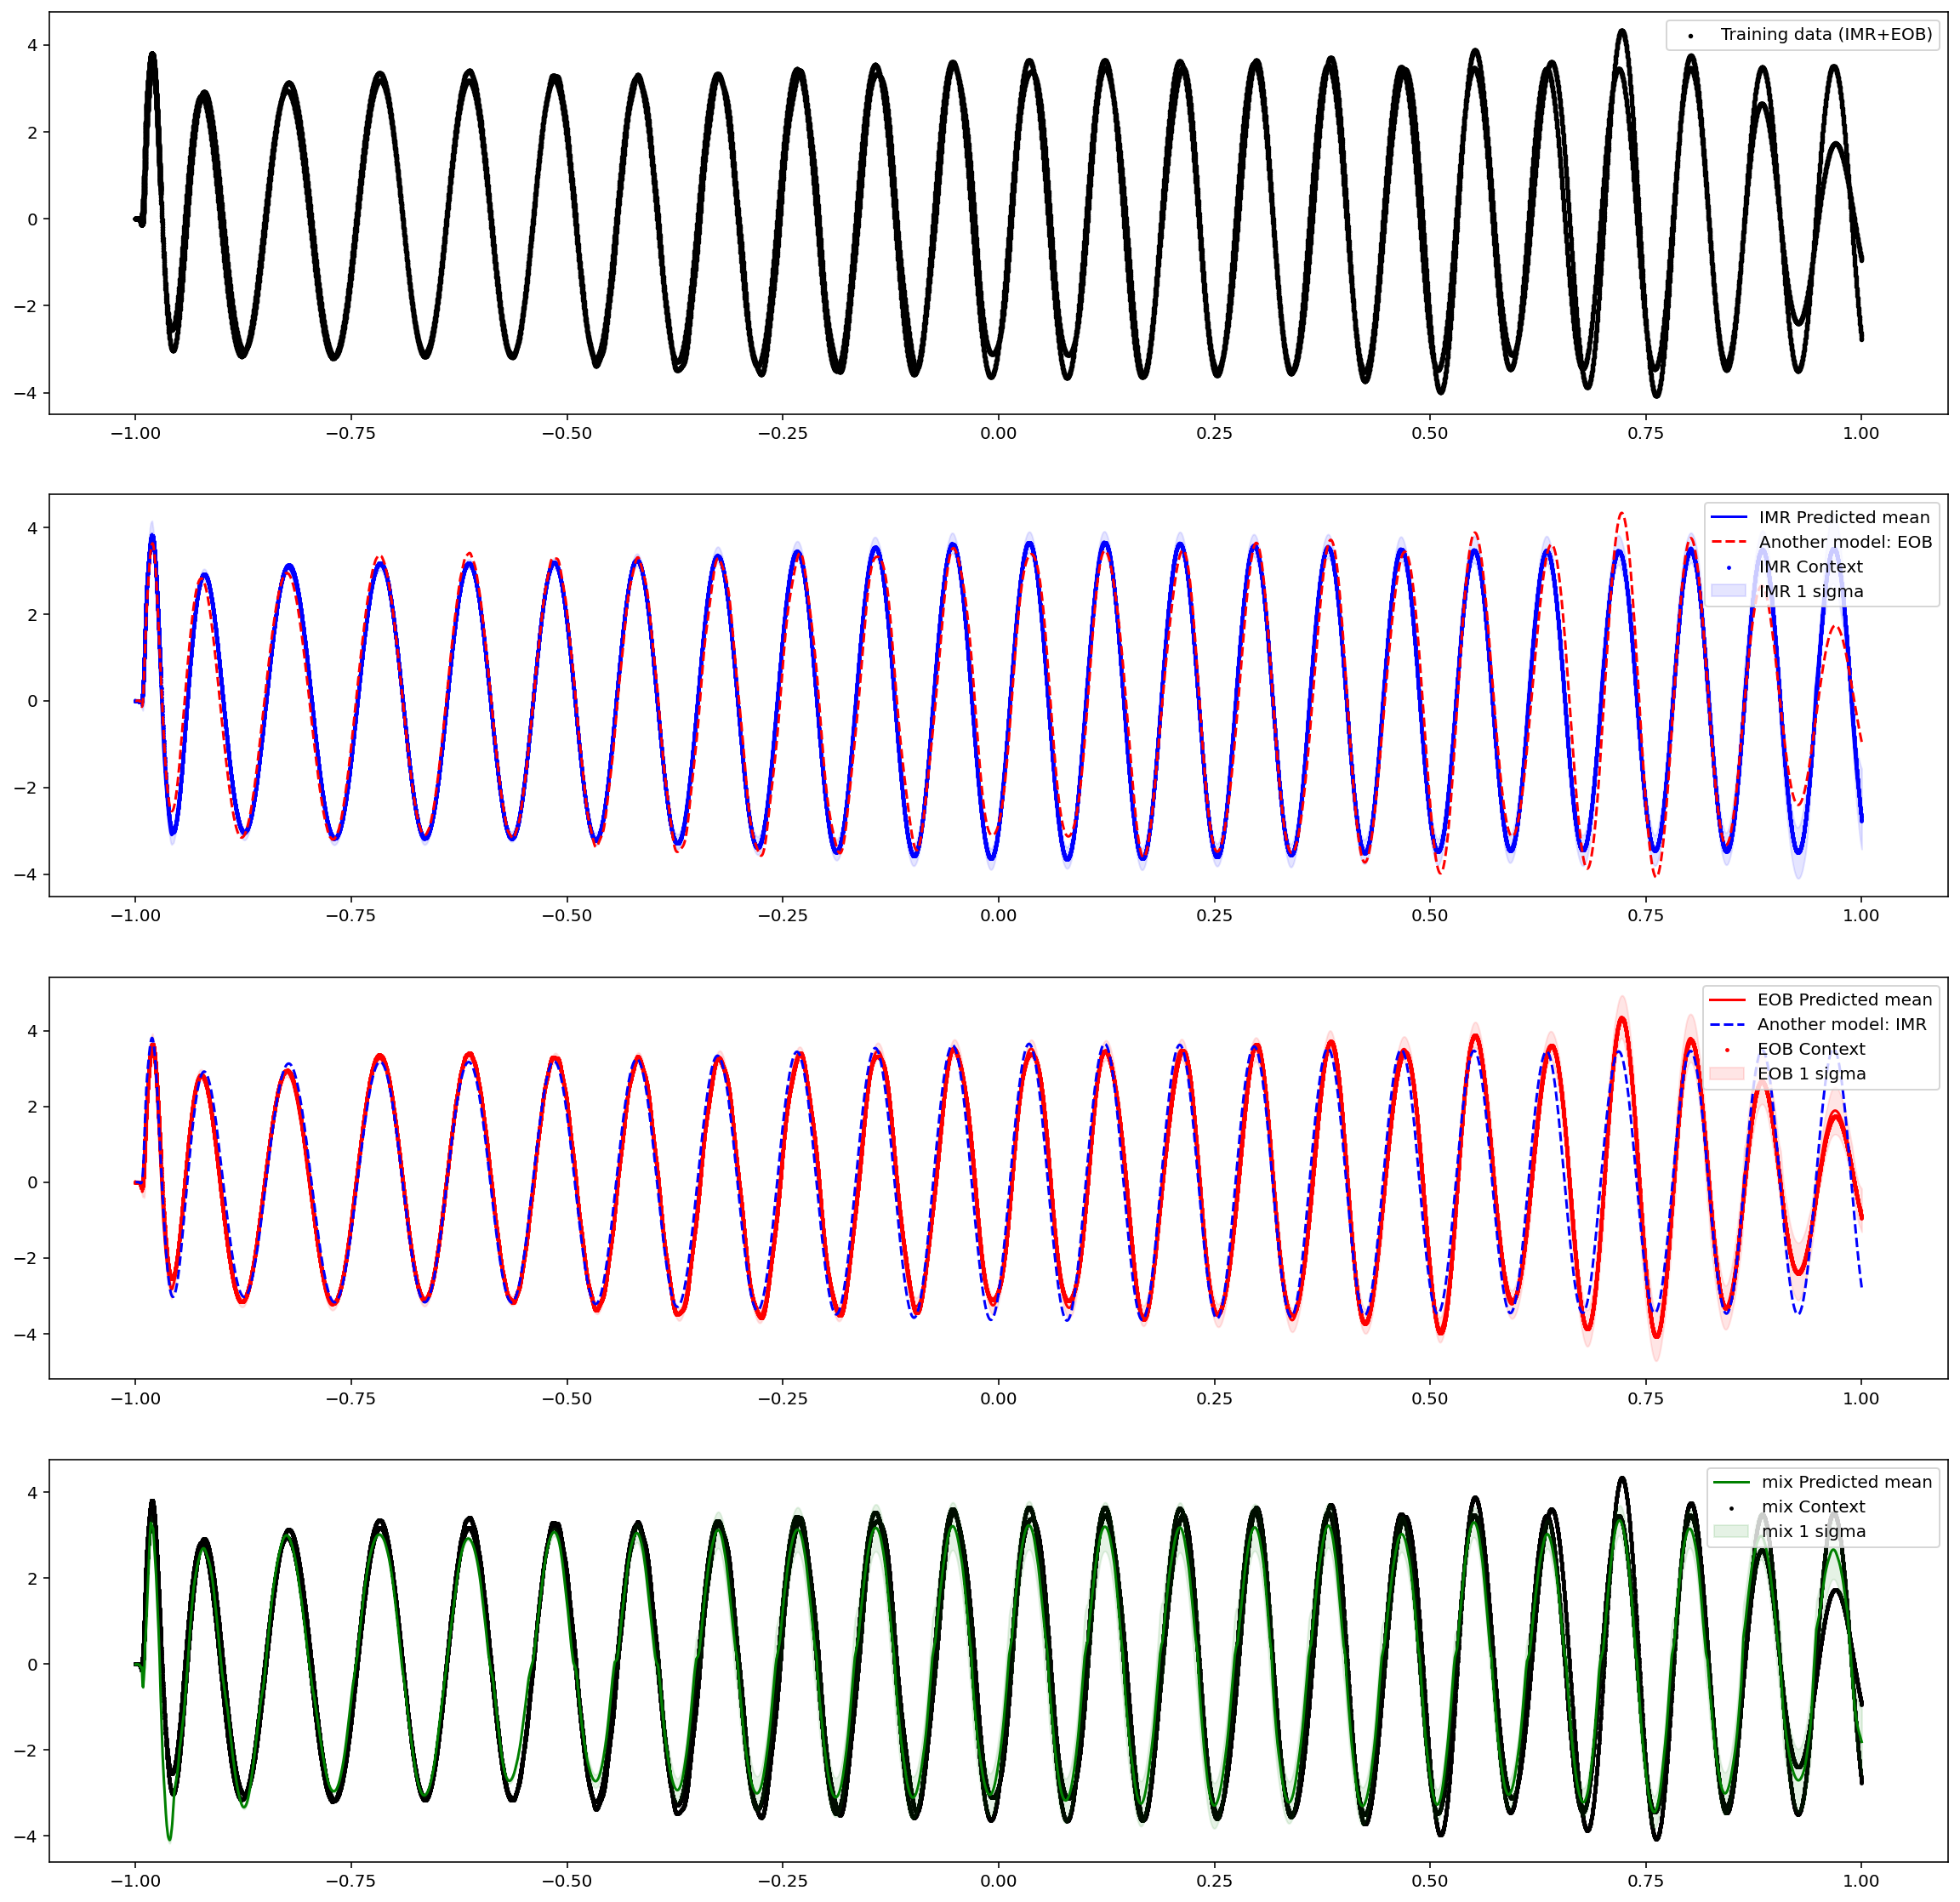

In [68]:
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()

plt.subplot(4,1,2)
plt.scatter(x_test_context_imr, y_test_context_imr, label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr, label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr-std_imr, y2=mean_imr+std_imr, label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob, label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)

plt.subplot(4,1,3)
plt.scatter(x_test_context_eob, y_test_context_eob, label='EOB Context', color='r',s=2)
plt.plot(x_test_target_eob, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze(), y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')
plt.plot(x_test_imr, y_test_imr, label='Another model: IMR', color='b',linestyle='--')
plt.legend()

plt.subplot(4,1,4)
plt.scatter(x_test_context_mix, y_test_context_mix, label='mix Context', color='k',s=2)
plt.plot(x_test_target_mix, mean_mix, label='mix Predicted mean', color='g',linestyle='-')
plt.fill_between(x=x_test_target_mix.squeeze(), y1=mean_mix-std_mix, y2=mean_mix+std_mix, label='mix 1 sigma', alpha=0.1, color='g')
plt.legend()

#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

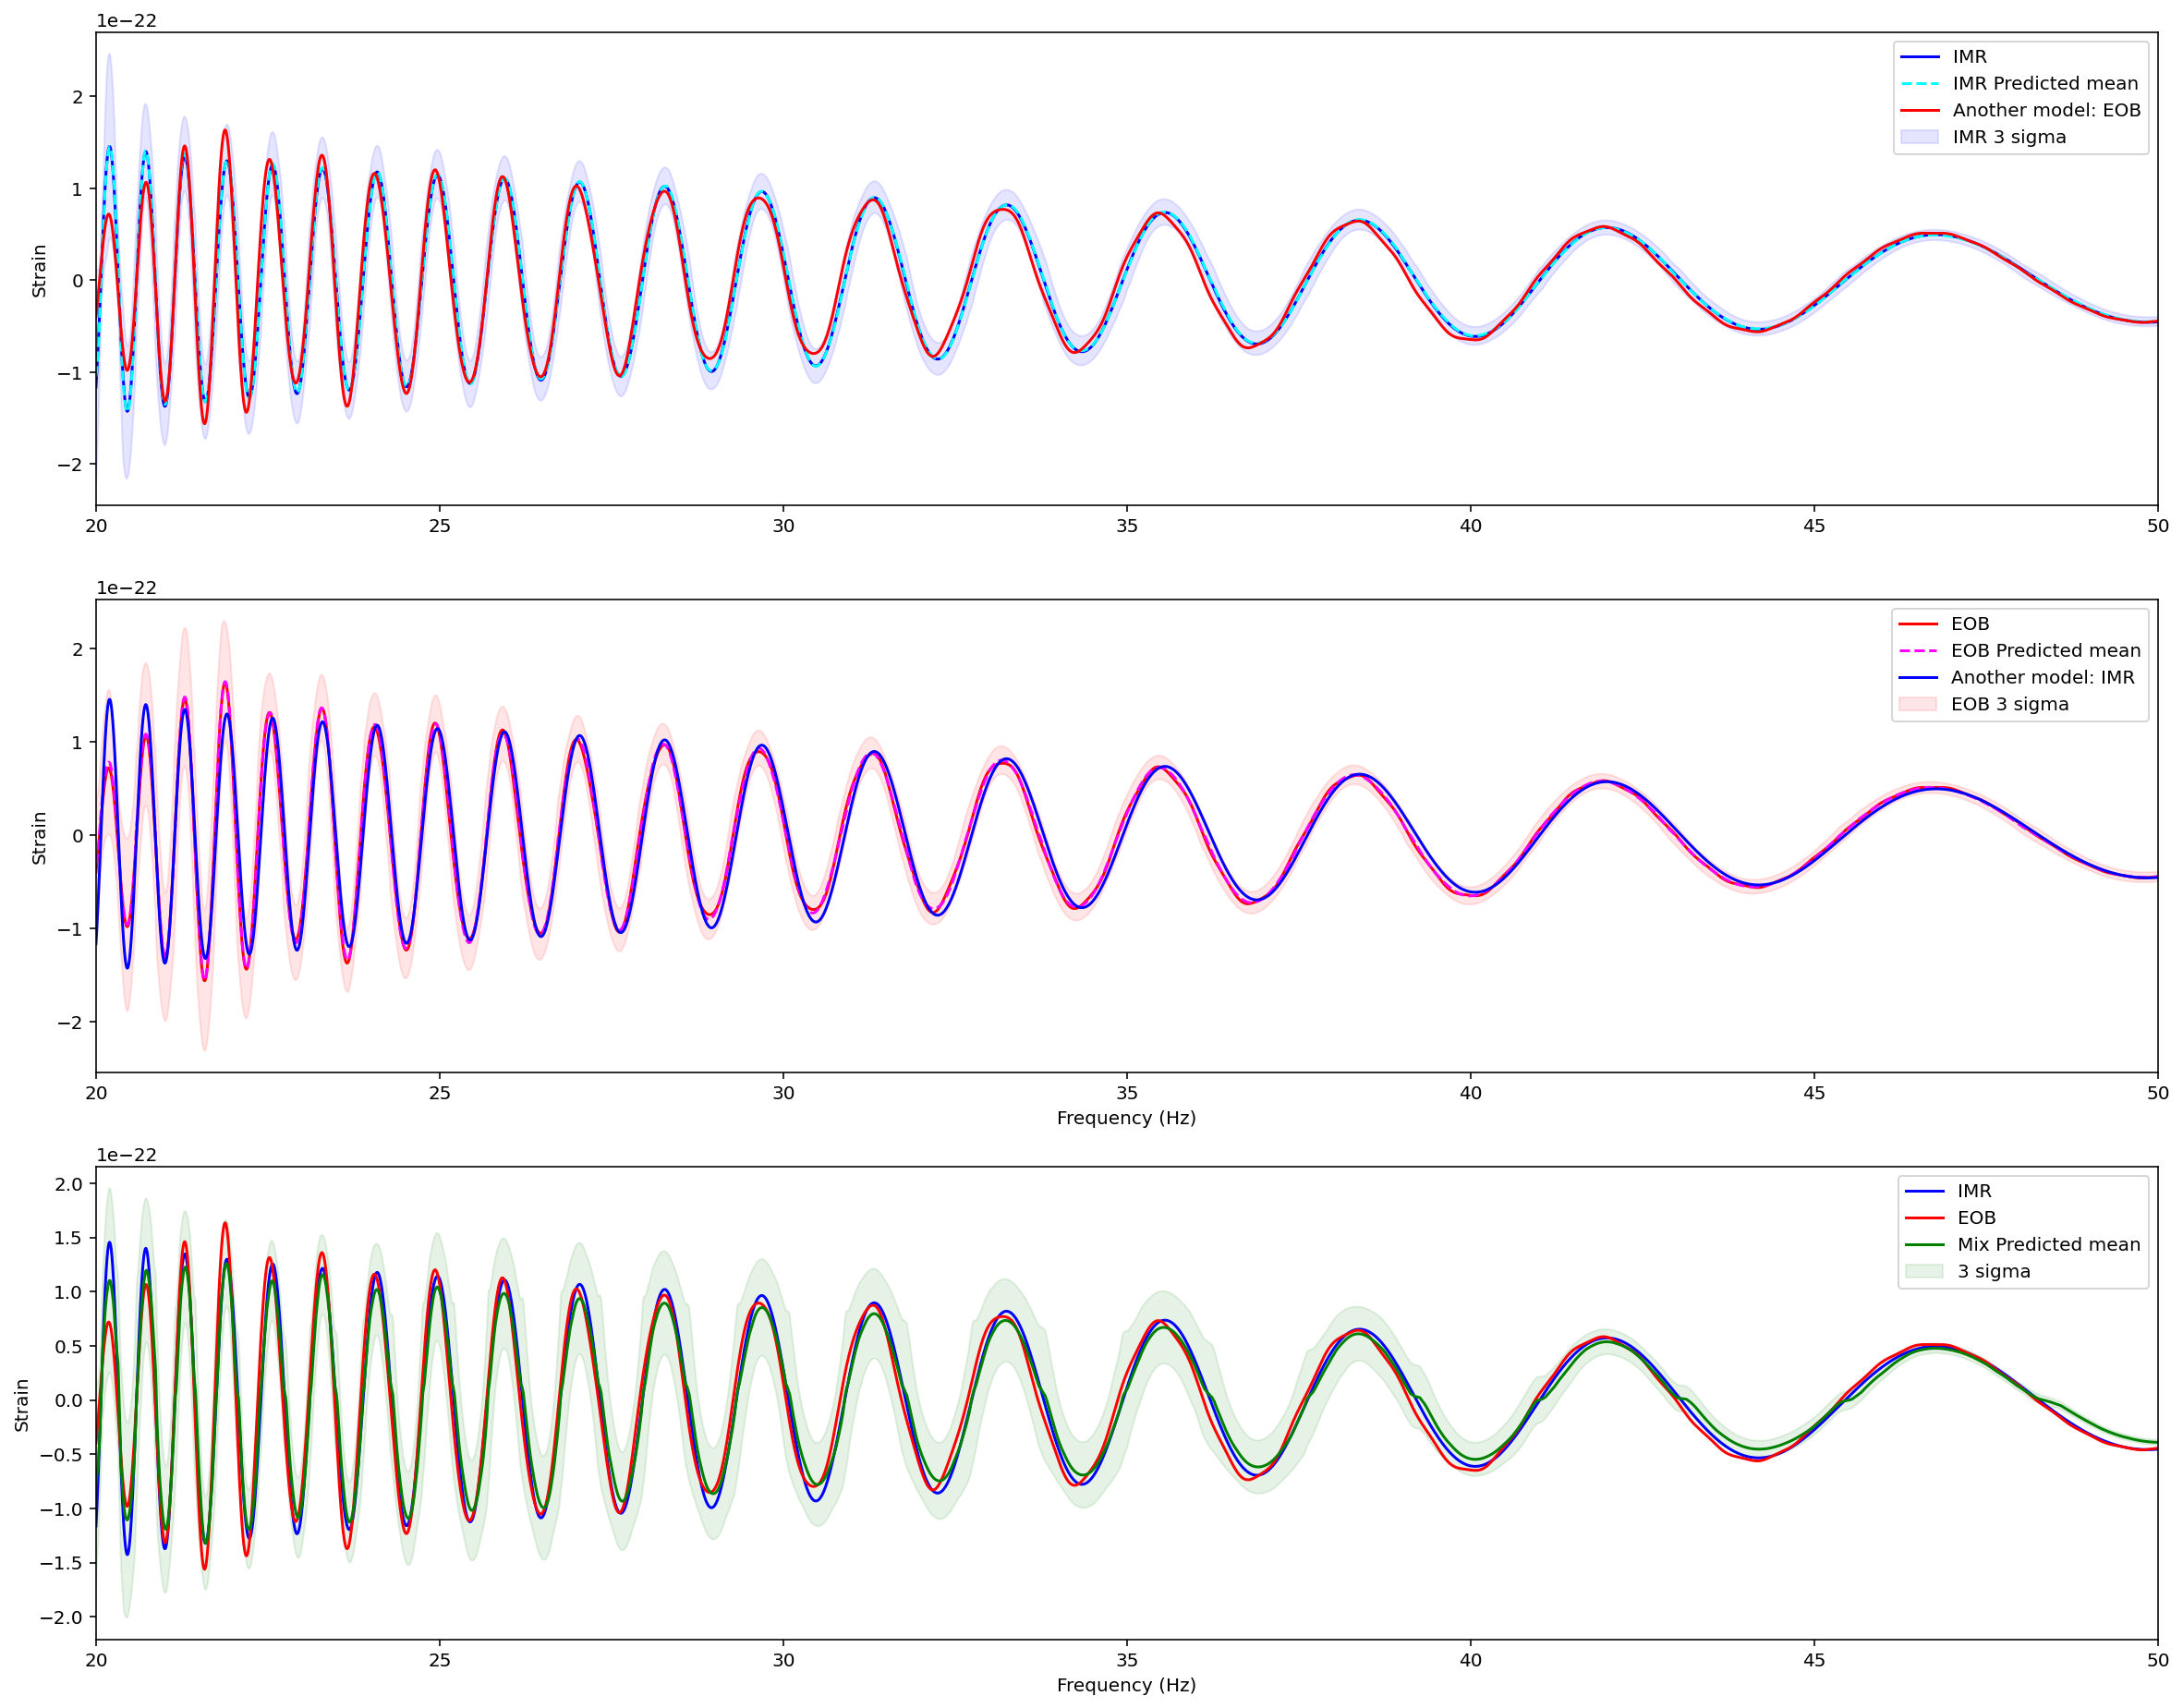

In [69]:
plt.figure(figsize=(20,16))
xlim_low=20
xlim_high=50
nsigma = 3

plt.subplot(3,1,1)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_imr, real_mean_test_imr, label='IMR Predicted mean', color='cyan',linestyle='--')
plt.fill_between(x=real_freq_test_imr, y1=real_mean_test_imr-nsigma*real_std_test_imr, y2=real_mean_test_imr+nsigma*real_std_test_imr,
                 label=f'IMR {nsigma} sigma', alpha=0.1, color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='Another model: EOB', color='r',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.ylabel('Strain')



plt.subplot(3,1,2)
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')
plt.plot(real_freq_test_eob, real_mean_test_eob, label='EOB Predicted mean', color='magenta',linestyle='--')
plt.fill_between(x=real_freq_test_eob, y1=real_mean_test_eob-nsigma*real_std_test_eob, y2=real_mean_test_eob+nsigma*real_std_test_eob,
                 label=f'EOB {nsigma} sigma', alpha=0.1, color='r')
plt.plot(real_freq_test_imr, real_amp_test_imr, label='Another model: IMR', color='b',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')

plt.subplot(3,1,3)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')

plt.plot(real_freq_test_mix,
            real_mean_test_mix, 
            label='Mix Predicted mean', 
            color='g',)
plt.fill_between(x=real_freq_test_mix,  #
                y1=real_mean_test_mix-nsigma*real_std_test_mix, 
                y2=real_mean_test_mix+nsigma*real_std_test_mix,
                label=f'{nsigma} sigma', alpha=0.1, color='g')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')


#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

# Cross real

In [70]:

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}
'''
for mode in ['plus', 'cross']:
    for part in ['real', 'imag']:
        train_label = f'{mode}_{part}'
        print(f"Loading {train_label}...")
        gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index, mode=mode, part=part)
        gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index, mode=mode, part=part)
        gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index, mode=mode, part=part)
        
        gw_datasets[train_label] = gw_dataset
        gw_test_datasets[train_label] = gw_test_dataset
        gw_valid_datasets[train_label] = gw_valid_dataset
'''

mode = 'cross'
part = 'real'
train_label = f'{mode}_{part}'
gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index, mode=mode, part=part)
gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index, mode=mode, part=part)
gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index, mode=mode, part=part)

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [71]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.3, b=0.5), targets_getter=GetRandomIndcs(a=0.3, b=0.5), #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [72]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [73]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=True,  # whether to load precomputed model or retrain
    is_continue_train=False,
    criterion=CNPFLoss,
    chckpnt_dirname=output_dir,
    device="cuda",
    lr=5e-5,
    decay_lr=10,
    seed=123,
    batch_size=4,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)




--- Training cross_real/ConvCNP/run_0 ---



  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1    22798.5824    11853.1647     +  53.8460


      2    58308.7353    11875.8504        49.4459


      3    11270.2958    10458.9547     +  49.1773


      4    10553.4659    10082.8023     +  49.5433


      5     9946.5083     9911.7474     +  48.4507


      6     9496.2761     8796.9047     +  50.9759


      7     8969.8824     8859.7899        51.4778


      8     8703.5904     8351.3441     +  49.5811


      9     8421.4911     8410.4548        50.0036


     10     8351.8287     8445.1296        51.0632


     11    18219.9419    20576.0011        49.7504


     12    11679.5651     9735.0250        49.6961


     13     9608.2728     9337.1552        49.7160


     14     9001.1917     8445.7699        49.9952


     15    11607.6173     8538.9235        50.0831


     16     8777.0567     8800.8706        53.1601


     17     8317.3345     7874.1036     +  49.1431


     18     8213.3239     7621.2183     +  49.3090


     19     8376.6157     7918.7534        50.7332


     20     7803.1943     7594.1655     +  49.2958


     21     8342.2750     7387.3228     +  50.3571


     22     7671.0797     7293.9301     +  49.1872


     23     7470.4432     7297.2860        49.1042


     24     7576.5386     7550.6553        50.2135


     25     7216.0013     8649.8952        51.4073


     26     7227.9015     6935.7163     +  49.5120


     27     6931.4172     7057.7254        43.9077


     28     7466.8544     6509.0387     +  43.4842


     29     6675.0265     6317.2245     +  45.5682


     30     7569.9847     6270.3719     +  43.8300


     31     6771.0578     6550.5184        44.1540


     32     6359.8120     6103.6117     +  43.9568


     33     6457.8919     6038.2904     +  43.4424


     34     6282.3537     6150.4915        47.0040


     35     6211.8640     5608.3837     +  43.8870


     36     6099.9542     5977.2159        43.7967


     37     6025.8703     5756.6714        45.1118


     38     5916.7966     6202.6071        44.0123


     39     5965.7776     5451.7032     +  44.8568


     40     5831.7214     7089.2916        43.7151


     41     5763.4440     6444.7418        43.3790


     42     5930.6554     7443.3422        45.9626


     43     5777.2913     5620.7176        44.7036


     44     5611.6891     8255.0677        44.9225


     45     5704.4445     5777.3113        44.5588


     46     5704.6896     5364.6495     +  43.7474


     47     5611.7369     5718.2098        45.5144


     48     5606.6906     5119.9857     +  43.9976


     49     5502.0766     5643.3177        44.7598


     50     5447.4655     5226.6939        44.1365


     51     5396.5190     5157.0867        45.9867


     52     5350.7879     5299.7568        45.5702


     53     5333.7532     5338.6218        43.5481


     54     5194.8753     5333.0167        44.6222


     55     5238.8622     5150.1313        44.5504


     56     5257.0297     6227.2142        43.9971


     57     5134.3978     5472.2786        44.7422


     58     5102.0938     6059.8060        43.2193


     59     5088.9242     5471.3198        45.8840


     60     5100.0869     4519.9828     +  44.9464


     61     4923.4160     6070.1316        43.8535


     62     4893.2247     4817.2334        45.1110


     63     4918.5236     4824.1588        43.3957


     64     4865.8344     4576.5182        44.4565


     65     4795.7482     4579.1985        44.2913


     66     4814.7602     5180.0529        43.6246


     67     4853.8261     4873.7333        45.0548


     68     4718.2303     4940.7184        45.6839


     69     4733.0788     4270.5983     +  44.6983


     70     4610.9258     6019.8764        45.5302


     71     4540.3583     4508.0432        44.2217


     72     4648.5170     4663.4114        45.5726


     73     4460.5663     5916.1558        44.0193


     74     4402.4980     5115.6112        44.0331


     75     4424.7028     4238.1101     +  44.6288


     76     4355.8655     4055.4065     +  46.1518


     77     4279.9396     4190.1868        44.8748


     78     4411.4895     5226.2559        44.3557


     79     4151.5493     4097.3081        44.1621


     80     4275.7625     4041.9352     +  44.7472


     81     4225.6484     3893.6788     +  44.4178


     82     4162.1354     4292.5028        44.9709


     83     4178.8377     5390.3475        43.8908


     84     4150.3387     4161.7966        44.8438


     85     4064.4840     4020.7323        46.6875


     86     4068.7736     3964.9131        44.3923


     87     4034.2007     3823.6537     +  45.2830


     88     3937.9765     3762.0049     +  44.0925


     89     4020.4246     3886.6594        44.1550


     90     3956.3115     3948.4955        45.2520


     91     3973.3704     3848.3340        44.0149


     92     3889.3547     3602.2284     +  44.7215


     93     3945.1004     3942.3187        45.9403


     94     3873.5343     3844.7093        44.7336


     95     3921.9693     3986.0363        45.5956


     96     3840.4731     4078.2967        44.3638


     97     3871.6008     3490.2203     +  45.5912


     98     3795.9080     3931.6698        44.7206


     99     3809.1649     3718.7353        44.8163


    100     3797.7417     3924.1552        45.5317


cross_real/ConvCNP/run_0 | best epoch: 97 | train loss: 3795.908 | valid loss: 3490.2203 | test log likelihood: -4204.5557


In [74]:
model_pv2v4p = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

In [75]:
gw_test_dataset.waveform_models

array(['IMRPhenomPv2', 'SEOBNRv4P'], dtype='<U12')

In [76]:
#look_approx = 'IMRPhenomPv2'
look_index = 2
chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2')
x_test_eob, y_test_eob = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P')

len_data = len(x_test_imr)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
x_yest_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
x_yest_target_eob = y_test_eob[target_index]


x_test_context_mix, y_test_context_mix = gw_test_dataset[look_index]
x_test_target_mix, y_test_target_mix = gw_test_dataset[look_index]


In [77]:
x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2', rescalex=False)
x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

x_test_target_eob_unsc, y_test_target_eob_unsc = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P', rescalex=False)
x_test_target_eob_unsc = x_test_target_eob_unsc.squeeze().numpy()
y_test_target_eob_unsc = y_test_target_eob_unsc.squeeze().numpy()

In [78]:
nsample = 1
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)
mean_mix, std_mix = gwutils.get_predictions(model_pv2v4p, x_test_context_mix.unsqueeze(0), y_test_context_mix.unsqueeze(0),
                                    x_test_target_mix.unsqueeze(0), nsample)

In [79]:
real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


real_freq_test_eob, real_amp_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [y_test_target_eob_unsc], chirp_mass_look)
real_freq_test_eob, real_mean_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [mean_eob], chirp_mass_look)
real_freq_test_eob, real_std_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [std_eob], chirp_mass_look)

real_freq_test_mix, real_mean_test_mix = gwutils.unscale_scaled_fdwaveforms(np.sort(np.append(x_test_target_imr_unsc,x_test_target_imr_unsc)), [mean_mix], chirp_mass_look)
real_freq_test_mix, real_std_test_mix = gwutils.unscale_scaled_fdwaveforms(np.sort(np.append(x_test_target_imr_unsc,x_test_target_imr_unsc)), [std_mix], chirp_mass_look)

real_amp_test_imr = real_amp_test_imr[0]
real_mean_test_imr = real_mean_test_imr[0]
real_std_test_imr = real_std_test_imr[0]
real_amp_test_eob = real_amp_test_eob[0]
real_mean_test_eob = real_mean_test_eob[0]
real_std_test_eob = real_std_test_eob[0]
real_mean_test_mix = real_mean_test_mix[0]
real_std_test_mix = real_std_test_mix[0]


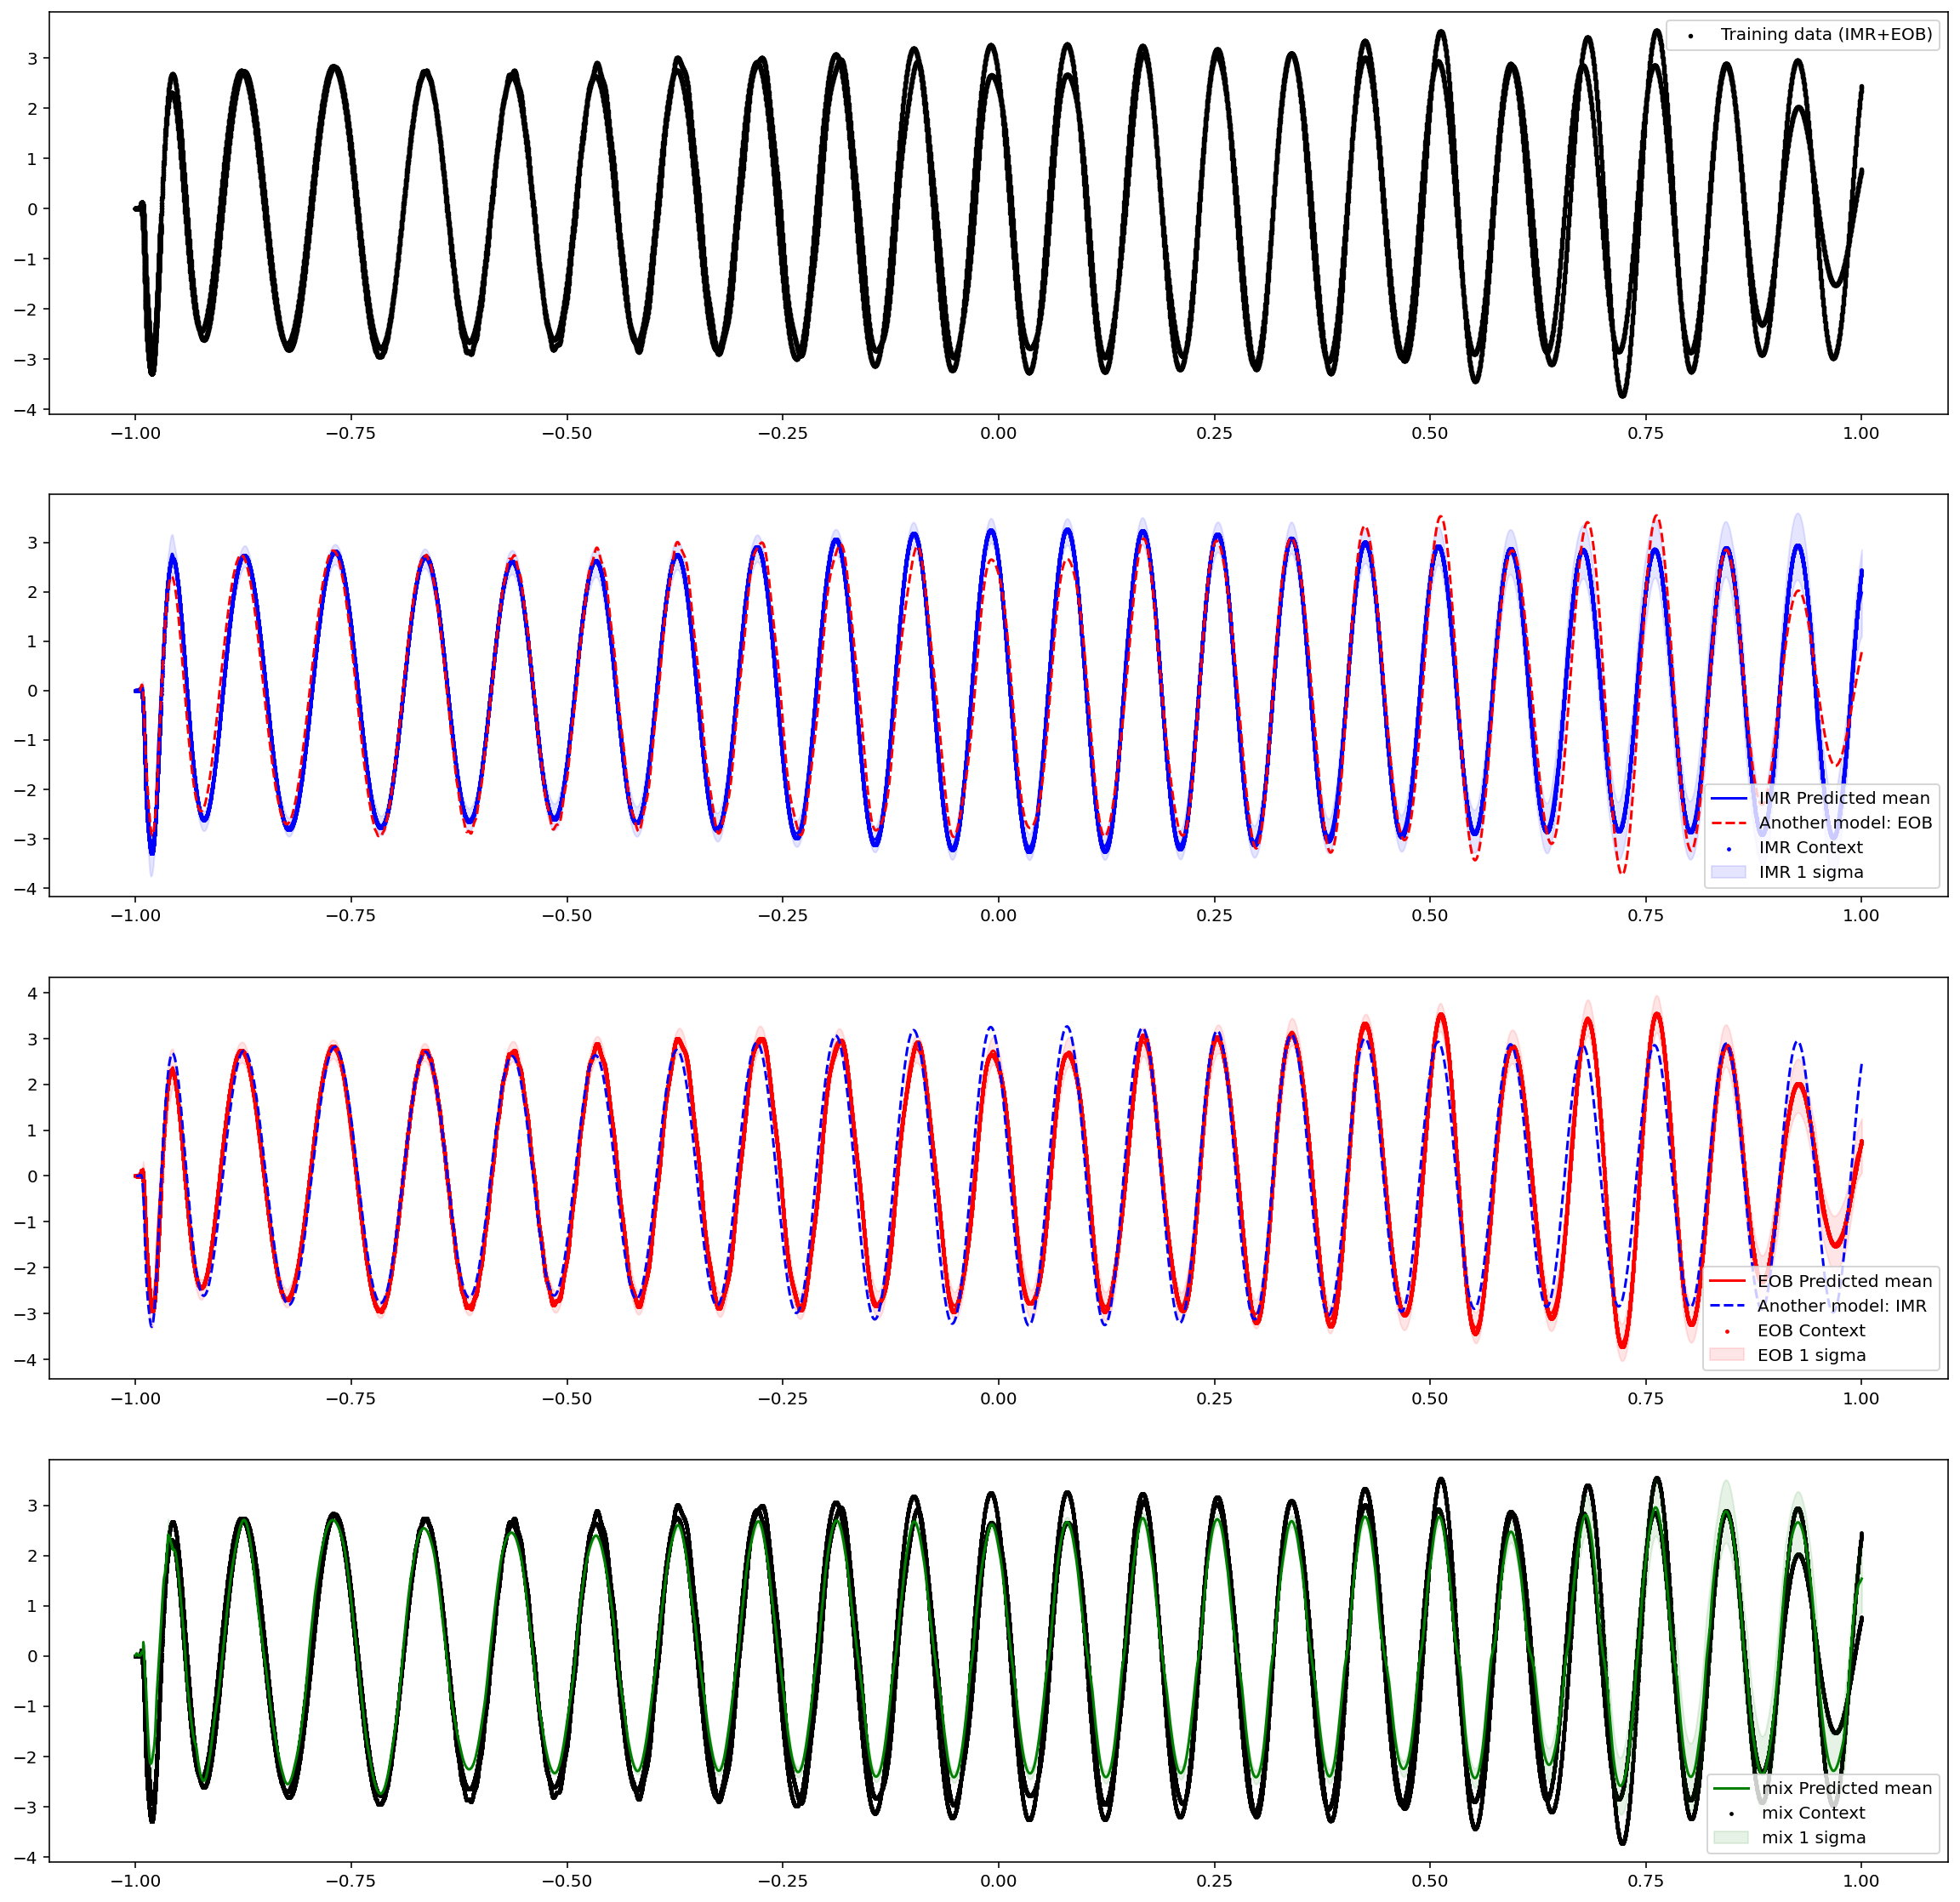

In [80]:
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()

plt.subplot(4,1,2)
plt.scatter(x_test_context_imr, y_test_context_imr, label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr, label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr-std_imr, y2=mean_imr+std_imr, label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob, label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)

plt.subplot(4,1,3)
plt.scatter(x_test_context_eob, y_test_context_eob, label='EOB Context', color='r',s=2)
plt.plot(x_test_target_eob, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze(), y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')
plt.plot(x_test_imr, y_test_imr, label='Another model: IMR', color='b',linestyle='--')
plt.legend()

plt.subplot(4,1,4)
plt.scatter(x_test_context_mix, y_test_context_mix, label='mix Context', color='k',s=2)
plt.plot(x_test_target_mix, mean_mix, label='mix Predicted mean', color='g',linestyle='-')
plt.fill_between(x=x_test_target_mix.squeeze(), y1=mean_mix-std_mix, y2=mean_mix+std_mix, label='mix 1 sigma', alpha=0.1, color='g')
plt.legend()

#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

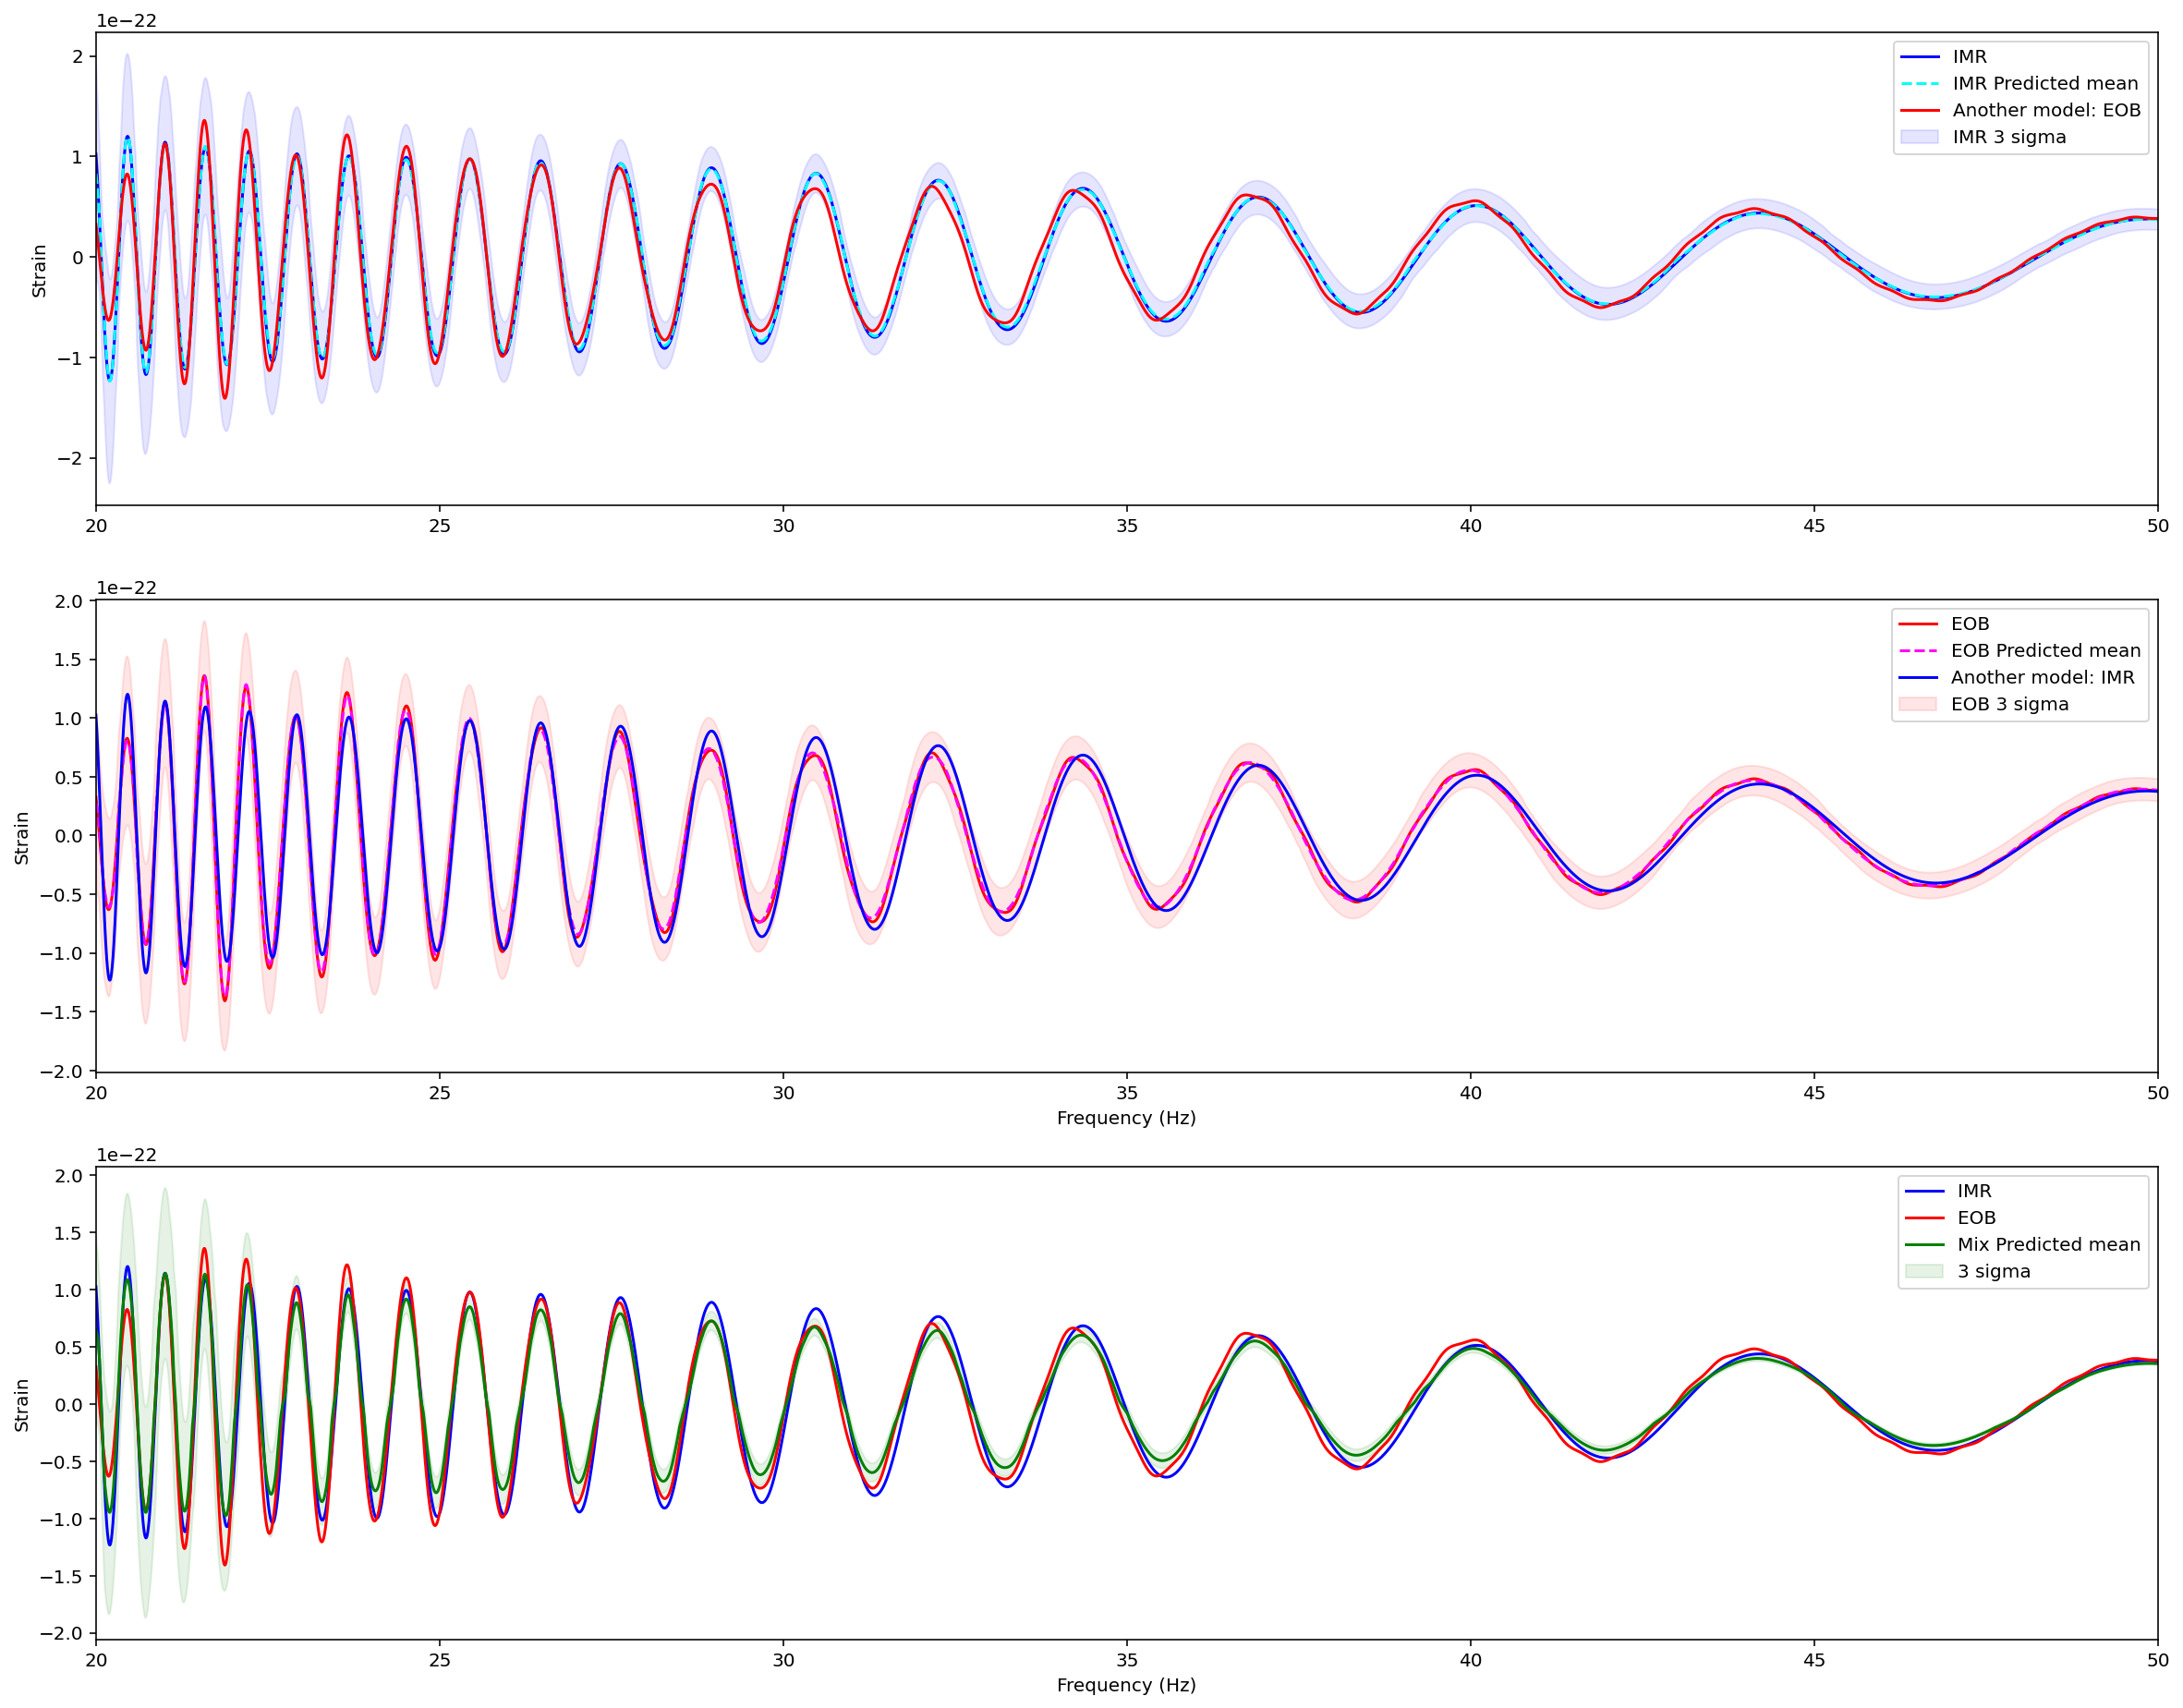

In [81]:
plt.figure(figsize=(20,16))
xlim_low=20
xlim_high=50
nsigma = 3

plt.subplot(3,1,1)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_imr, real_mean_test_imr, label='IMR Predicted mean', color='cyan',linestyle='--')
plt.fill_between(x=real_freq_test_imr, y1=real_mean_test_imr-nsigma*real_std_test_imr, y2=real_mean_test_imr+nsigma*real_std_test_imr,
                 label=f'IMR {nsigma} sigma', alpha=0.1, color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='Another model: EOB', color='r',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.ylabel('Strain')



plt.subplot(3,1,2)
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')
plt.plot(real_freq_test_eob, real_mean_test_eob, label='EOB Predicted mean', color='magenta',linestyle='--')
plt.fill_between(x=real_freq_test_eob, y1=real_mean_test_eob-nsigma*real_std_test_eob, y2=real_mean_test_eob+nsigma*real_std_test_eob,
                 label=f'EOB {nsigma} sigma', alpha=0.1, color='r')
plt.plot(real_freq_test_imr, real_amp_test_imr, label='Another model: IMR', color='b',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')

plt.subplot(3,1,3)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')

plt.plot(real_freq_test_mix,
            real_mean_test_mix, 
            label='Mix Predicted mean', 
            color='g',)
plt.fill_between(x=real_freq_test_mix,  #
                y1=real_mean_test_mix-nsigma*real_std_test_mix, 
                y2=real_mean_test_mix+nsigma*real_std_test_mix,
                label=f'{nsigma} sigma', alpha=0.1, color='g')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')


#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

# Cross imag

In [82]:

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}
'''
for mode in ['plus', 'cross']:
    for part in ['real', 'imag']:
        train_label = f'{mode}_{part}'
        print(f"Loading {train_label}...")
        gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index, mode=mode, part=part)
        gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index, mode=mode, part=part)
        gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index, mode=mode, part=part)
        
        gw_datasets[train_label] = gw_dataset
        gw_test_datasets[train_label] = gw_test_dataset
        gw_valid_datasets[train_label] = gw_valid_dataset
'''

mode = 'cross'
part = 'imag'
train_label = f'{mode}_{part}'
gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index, mode=mode, part=part)
gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index, mode=mode, part=part)
gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index, mode=mode, part=part)

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [83]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.3, b=0.5), targets_getter=GetRandomIndcs(a=0.3, b=0.5), #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [84]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [85]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=True,  # whether to load precomputed model or retrain
    is_continue_train=False,
    criterion=CNPFLoss,
    chckpnt_dirname=output_dir,
    device="cuda",
    lr=5e-5,
    decay_lr=10,
    seed=123,
    batch_size=4,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)




--- Training cross_imag/ConvCNP/run_0 ---



  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1    25096.0293    14720.6964     +  58.8923


      2    11044.2787     9445.0160     +  59.1731


      3   244412.0679    26179.0094        58.2641


      4    19880.7506    14715.3701        58.6280


      5    13840.7173    13485.3982        57.9436


      6    12621.0027    10961.4632        60.9842


      7    12135.9121    10818.1184        59.7655


      8    11758.2916    14355.5675        56.2233


      9    11133.2222    10109.6591        55.8309


     10    10839.3614    10491.1605        55.2552


     11    10206.4691     9623.6319        56.2491


     12    10016.9325     9247.4645     +  60.3068


     13     9482.7817     9372.8246        55.1293


     14     9118.6261     8914.6704     +  48.8643


     15     8920.8516     8269.9414     +  49.9797


     16     8982.7752     9662.8125        49.9427


     17     8530.6920     7931.5754     +  48.9015


     18     8581.1407     8338.8227        48.1345


     19     8738.1218     8212.5845        48.4454


     20     8665.1313     7753.6571     +  49.0428


     21     8320.9226     8479.2744        49.6366


     22     8502.6211     9010.1603        49.5646


     23     8070.0704     8980.2224        49.5333


     24     8140.6262     8417.6656        49.0016


     25     7742.2043     7650.5337     +  49.3715


     26     7810.6280     8352.5131        48.3832


     27     7610.1177     7261.8721     +  48.8397


     28     7376.5751     7009.0957     +  49.4916


     29     7296.8369     7059.0046        48.9198


     30     7517.7827     7633.5724        50.0773


     31     7100.3153     9417.5100        48.4206


     32     6755.0748     9429.6677        51.4604


     33     6839.3629    10064.0324        49.1581


     34     6763.5925     7711.5079        49.2779


     35     6693.5571     6218.3945     +  49.3232


     36     6706.1845     7425.9126        48.6502


     37     6543.3911     6617.8374        48.7859


     38     6432.2676     8864.7038        49.7194


     39     6377.5178     6175.0985     +  48.8603


     40     6365.7470     6158.2580     +  49.4518


     41     6129.1758     6075.4078     +  50.4854


     42     6155.3510     6441.7061        48.8978


     43     6142.5074     5760.1316     +  48.1472


     44     6104.6429     5851.2008        48.9119


     45     6028.0351     9464.0401        49.2022


     46     6024.3568     6032.3663        47.9111


     47     6039.1597     8960.6064        48.8974


     48     5854.7231     5679.3911     +  48.6315


     49     6102.9245     6034.9579        51.4274


     50     5896.8273     7890.1922        49.4097


     51     5845.3047     7331.1178        48.5791


     52     5835.2017     7017.9186        49.1009


     53     5661.0324     7565.5909        48.9631


     54     5718.1569     5585.4871     +  48.6223


     55     5720.7205     6065.8742        50.9335


     56     5696.5608     5999.5718        48.0766


     57     5627.3041     5579.5338     +  50.7057


     58     5661.3066     5476.0749     +  49.2695


     59     5605.1210     5885.1383        48.3638


     60     5577.6611     6086.2303        49.6186


     61     5531.2732     6922.7899        48.5900


     62     5405.2143     6205.3037        48.3495


     63     5395.8827     5373.2233     +  48.6175


     64     5471.3547     5094.0731     +  47.3704


     65     5446.4876     6346.5329        48.1198


     66     5338.9141     8213.3799        47.2893


     67     5465.6176     5882.3417        47.1086


     68     5360.1129     5369.6224        47.8098


     69     5401.0304     5159.1718        47.5652


     70     5362.8134     6084.8161        47.7810


     71     5179.0454     4837.7904     +  47.6645


     72     5330.6827     5615.9365        46.7983


     73     5164.3792     4841.8883        47.7142


     74     5170.2440     8314.1155        47.5689


     75     5132.7660     5126.1261        46.9104


     76     5175.7795     4885.2460        47.1664


     77     5054.7112     4970.0955        46.6503


     78     5124.9345     4713.9546     +  47.4068


     79     4985.7819     4877.3677        46.6412


     80     5175.1290     6060.9016        44.9325


     81     4991.2863     4744.8966        41.4293


     82     4987.3232     5517.9220        41.7388


     83     5003.6791     5638.7188        42.6762


     84     4977.4899     5460.3301        41.4823


     85     4917.7058     5093.1284        41.4381


     86     4905.6408     4826.1723        41.6250


     87     4871.3356     5778.4482        41.6353


     88     4783.8632     4699.7451     +  42.4637


     89     4774.5175     5670.4740        40.7269


     90     4808.5133     5084.6592        41.4019


     91     4858.8032     4822.2356        41.9564


     92     4726.6729     4446.3260     +  41.2974


     93     4770.7776     4982.3551        41.9807


     94     4719.3230     5117.9897        41.0652


     95     4750.1623     4634.3766        41.5418


     96     4766.0894     4611.6092        42.4009


     97     4689.1334     4240.0233     +  40.9732


     98     4589.3841     4252.3496        41.6910


     99     4677.5792     4886.8279        41.3038


    100     4594.9192     5226.6930        41.3644


cross_imag/ConvCNP/run_0 | best epoch: 97 | train loss: 4589.3841 | valid loss: 4240.0233 | test log likelihood: -5439.4058


In [86]:
model_pv2v4p = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

In [87]:
gw_test_dataset.waveform_models

array(['IMRPhenomPv2', 'SEOBNRv4P'], dtype='<U12')

In [88]:
#look_approx = 'IMRPhenomPv2'
look_index = 2
chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2')
x_test_eob, y_test_eob = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P')

len_data = len(x_test_imr)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
x_yest_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
x_yest_target_eob = y_test_eob[target_index]


x_test_context_mix, y_test_context_mix = gw_test_dataset[look_index]
x_test_target_mix, y_test_target_mix = gw_test_dataset[look_index]


In [89]:
x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2', rescalex=False)
x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

x_test_target_eob_unsc, y_test_target_eob_unsc = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P', rescalex=False)
x_test_target_eob_unsc = x_test_target_eob_unsc.squeeze().numpy()
y_test_target_eob_unsc = y_test_target_eob_unsc.squeeze().numpy()

In [90]:
nsample = 1
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)
mean_mix, std_mix = gwutils.get_predictions(model_pv2v4p, x_test_context_mix.unsqueeze(0), y_test_context_mix.unsqueeze(0),
                                    x_test_target_mix.unsqueeze(0), nsample)

In [91]:
real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


real_freq_test_eob, real_amp_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [y_test_target_eob_unsc], chirp_mass_look)
real_freq_test_eob, real_mean_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [mean_eob], chirp_mass_look)
real_freq_test_eob, real_std_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [std_eob], chirp_mass_look)

real_freq_test_mix, real_mean_test_mix = gwutils.unscale_scaled_fdwaveforms(np.sort(np.append(x_test_target_imr_unsc,x_test_target_imr_unsc)), [mean_mix], chirp_mass_look)
real_freq_test_mix, real_std_test_mix = gwutils.unscale_scaled_fdwaveforms(np.sort(np.append(x_test_target_imr_unsc,x_test_target_imr_unsc)), [std_mix], chirp_mass_look)

real_amp_test_imr = real_amp_test_imr[0]
real_mean_test_imr = real_mean_test_imr[0]
real_std_test_imr = real_std_test_imr[0]
real_amp_test_eob = real_amp_test_eob[0]
real_mean_test_eob = real_mean_test_eob[0]
real_std_test_eob = real_std_test_eob[0]
real_mean_test_mix = real_mean_test_mix[0]
real_std_test_mix = real_std_test_mix[0]


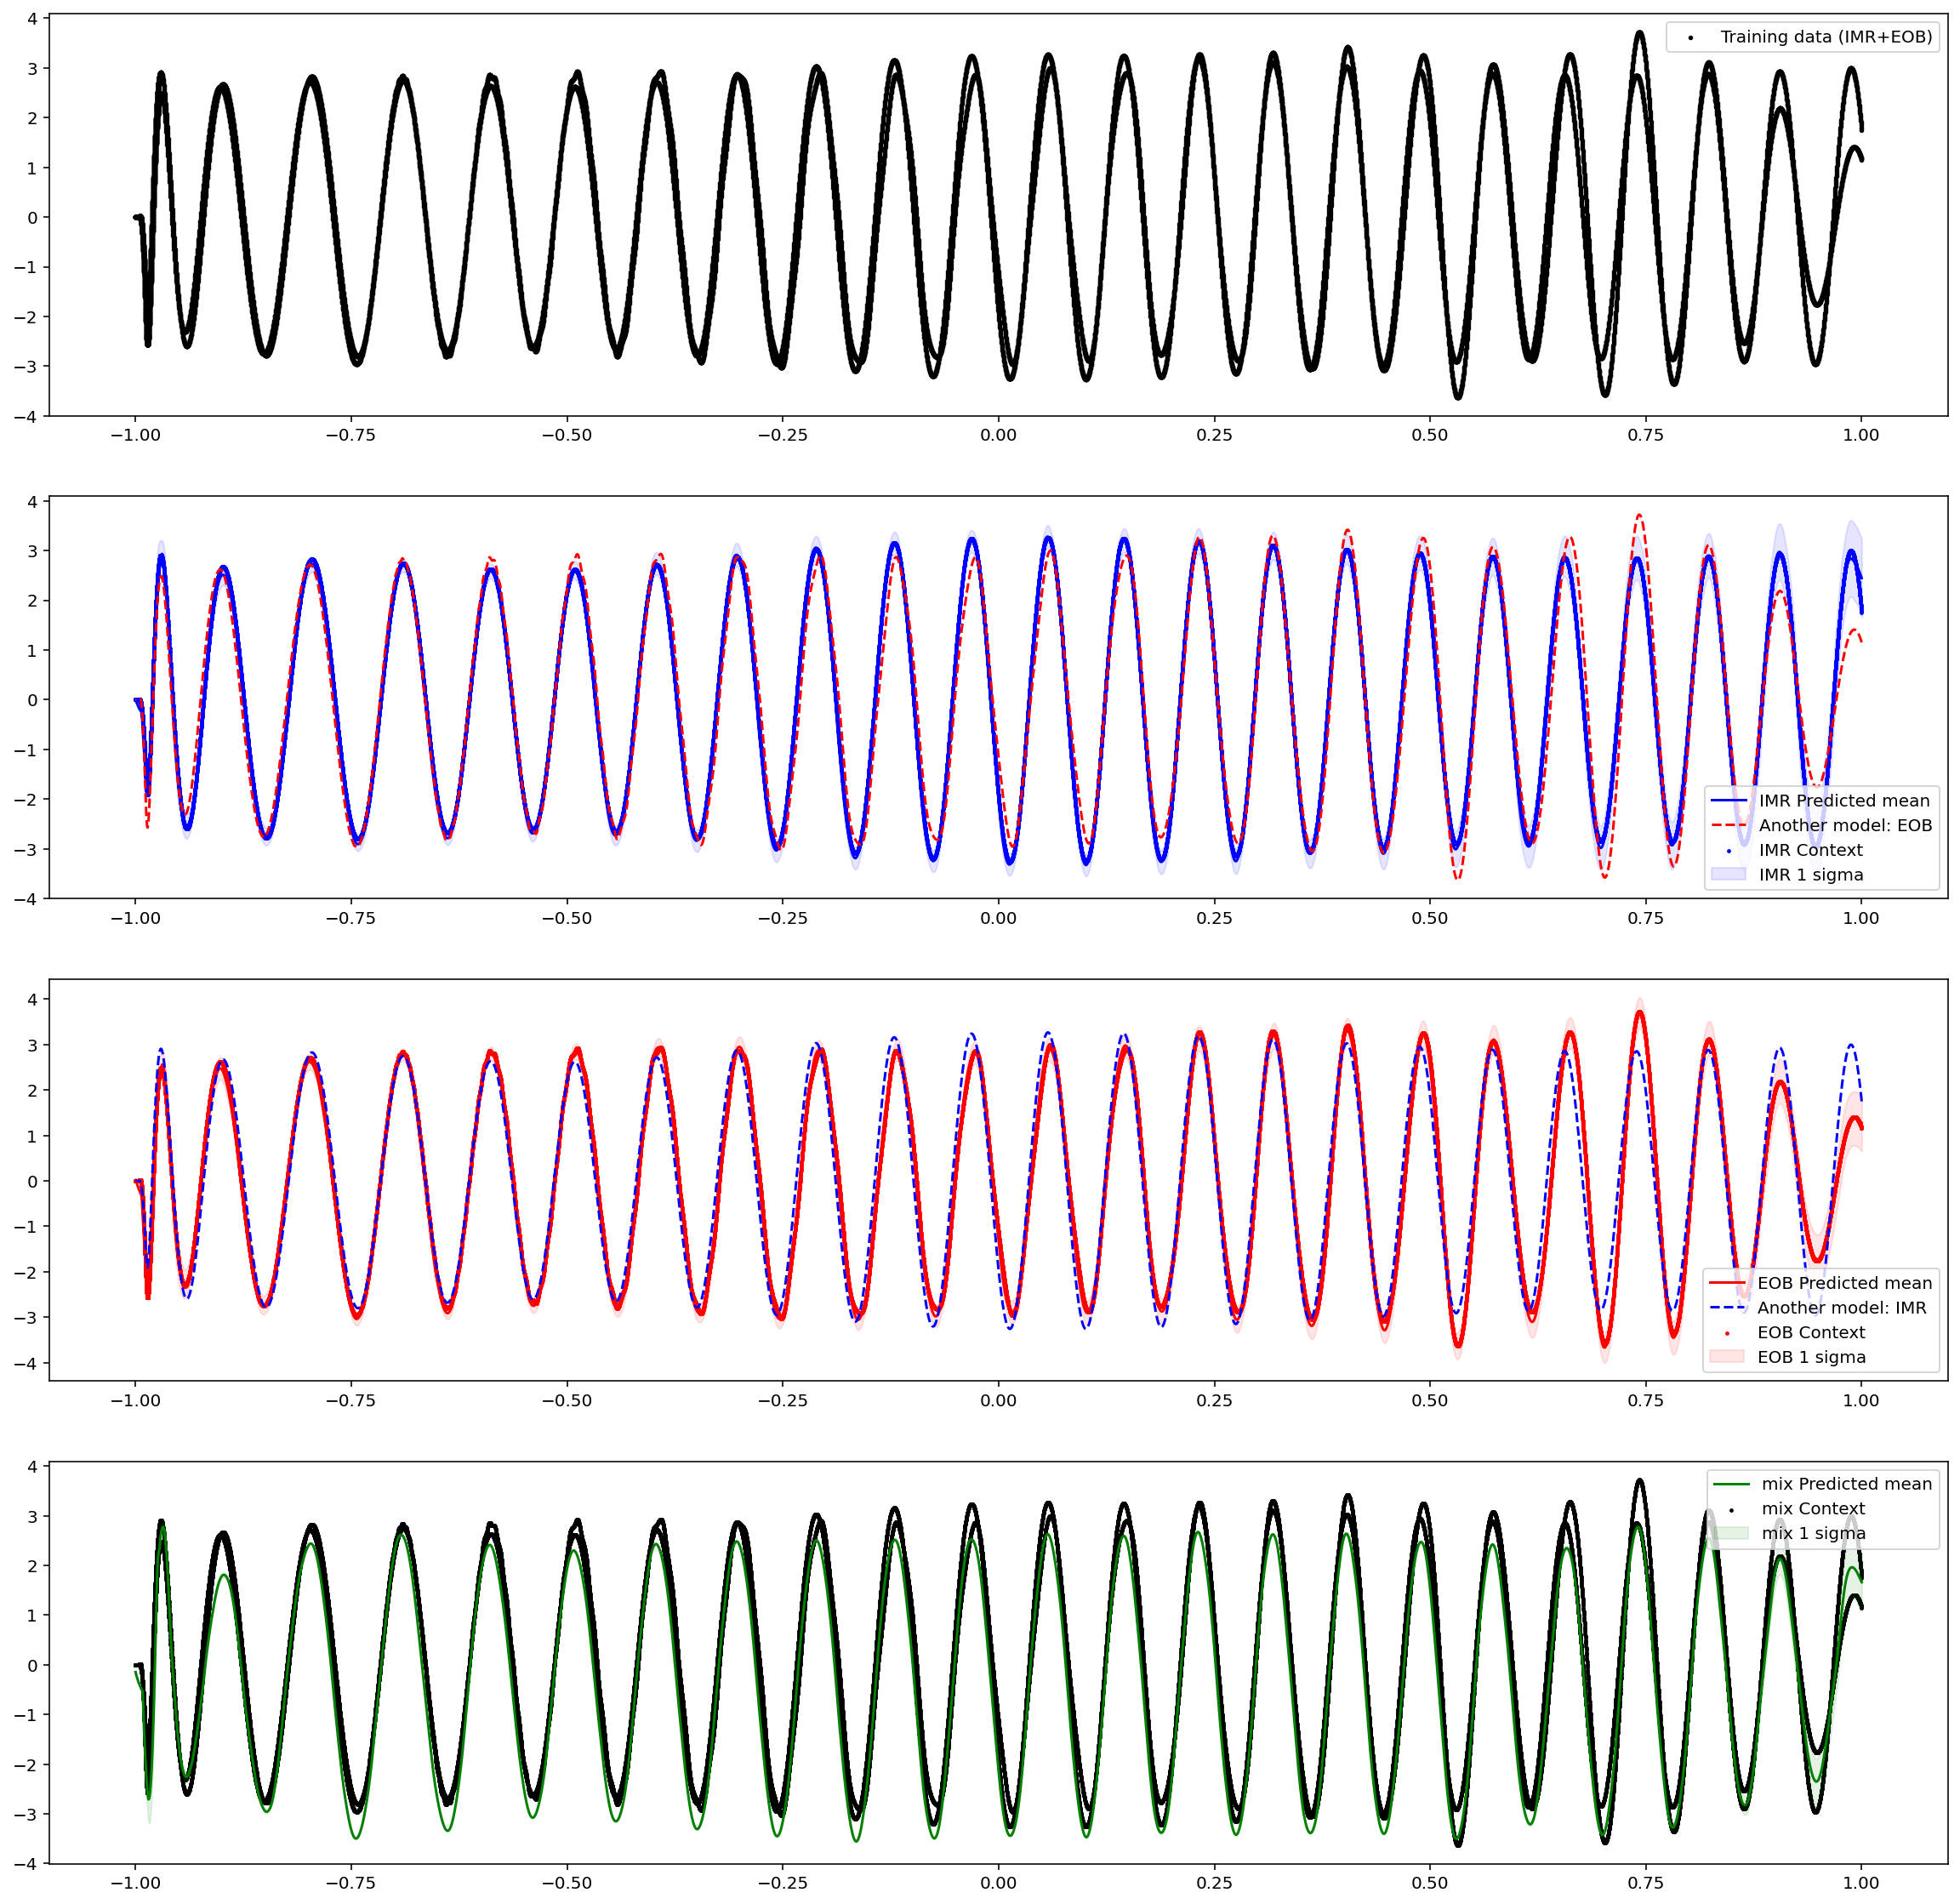

In [92]:
plt.figure(figsize=(20,20))
plt.subplot(4,1,1)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()

plt.subplot(4,1,2)
plt.scatter(x_test_context_imr, y_test_context_imr, label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr, label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr-std_imr, y2=mean_imr+std_imr, label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob, label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)

plt.subplot(4,1,3)
plt.scatter(x_test_context_eob, y_test_context_eob, label='EOB Context', color='r',s=2)
plt.plot(x_test_target_eob, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze(), y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')
plt.plot(x_test_imr, y_test_imr, label='Another model: IMR', color='b',linestyle='--')
plt.legend()

plt.subplot(4,1,4)
plt.scatter(x_test_context_mix, y_test_context_mix, label='mix Context', color='k',s=2)
plt.plot(x_test_target_mix, mean_mix, label='mix Predicted mean', color='g',linestyle='-')
plt.fill_between(x=x_test_target_mix.squeeze(), y1=mean_mix-std_mix, y2=mean_mix+std_mix, label='mix 1 sigma', alpha=0.1, color='g')
plt.legend()

#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

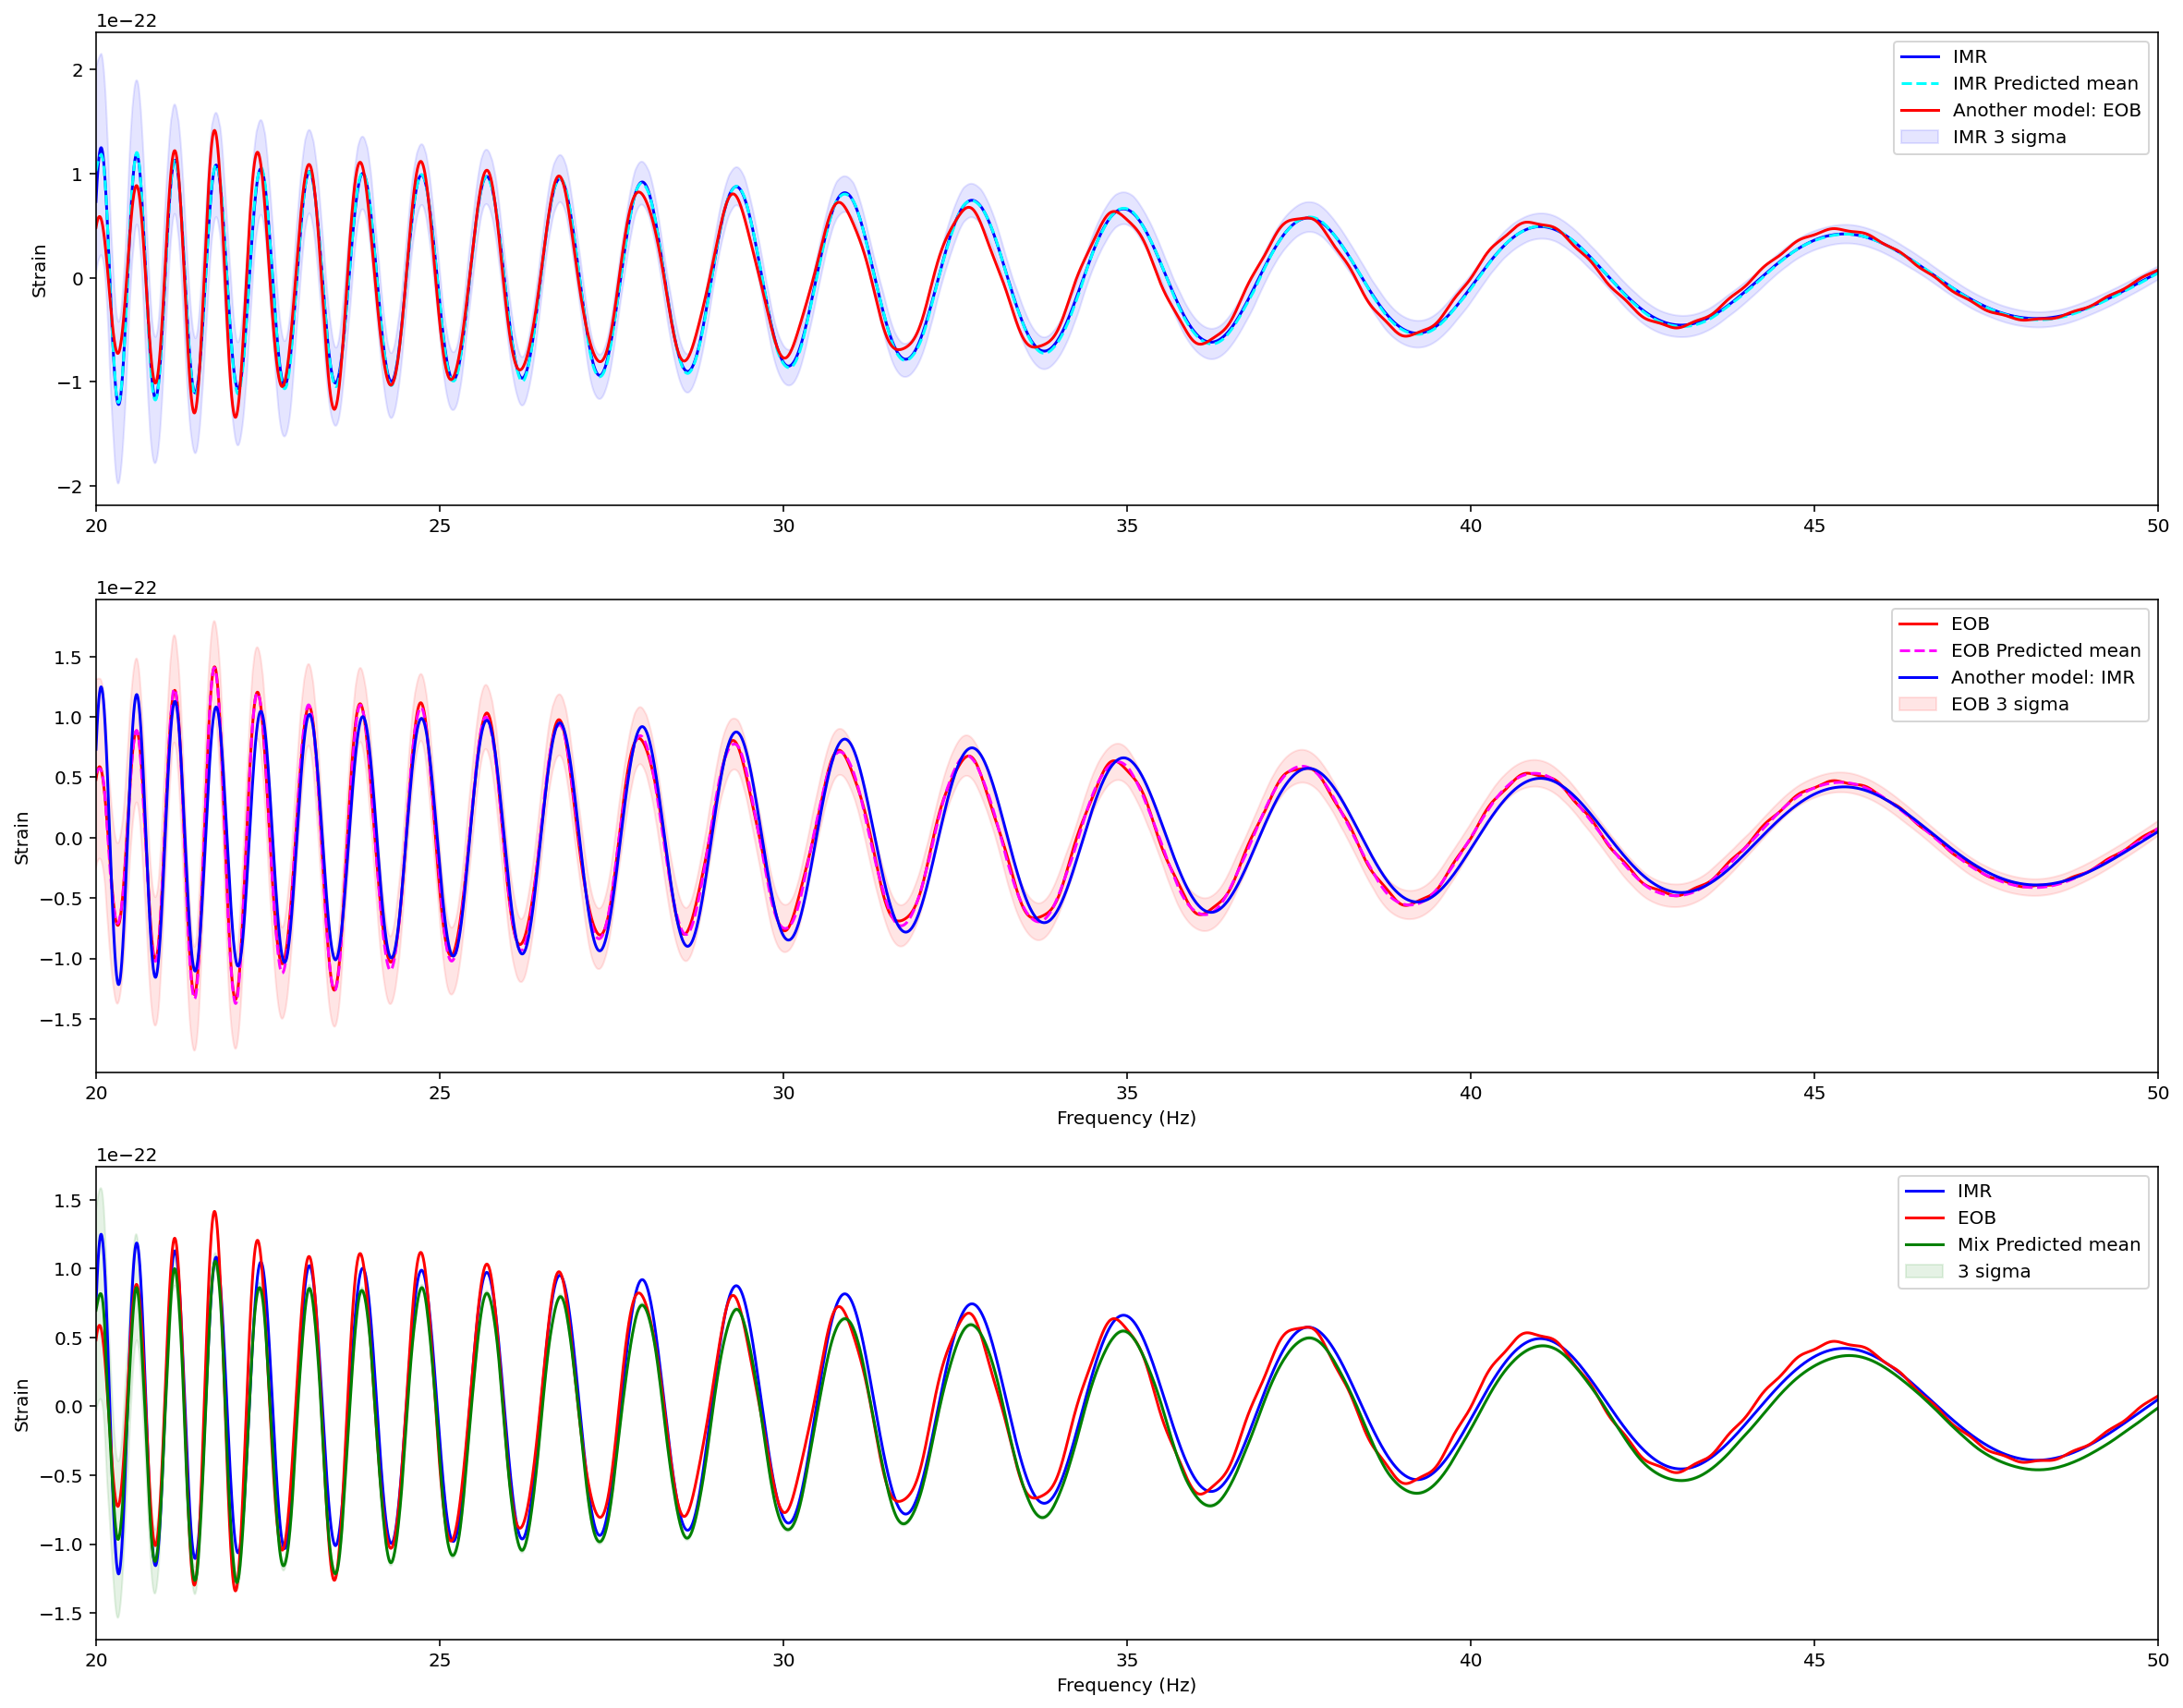

In [93]:
plt.figure(figsize=(20,16))
xlim_low=20
xlim_high=50
nsigma = 3

plt.subplot(3,1,1)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_imr, real_mean_test_imr, label='IMR Predicted mean', color='cyan',linestyle='--')
plt.fill_between(x=real_freq_test_imr, y1=real_mean_test_imr-nsigma*real_std_test_imr, y2=real_mean_test_imr+nsigma*real_std_test_imr,
                 label=f'IMR {nsigma} sigma', alpha=0.1, color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='Another model: EOB', color='r',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.ylabel('Strain')



plt.subplot(3,1,2)
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')
plt.plot(real_freq_test_eob, real_mean_test_eob, label='EOB Predicted mean', color='magenta',linestyle='--')
plt.fill_between(x=real_freq_test_eob, y1=real_mean_test_eob-nsigma*real_std_test_eob, y2=real_mean_test_eob+nsigma*real_std_test_eob,
                 label=f'EOB {nsigma} sigma', alpha=0.1, color='r')
plt.plot(real_freq_test_imr, real_amp_test_imr, label='Another model: IMR', color='b',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')

plt.subplot(3,1,3)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')

plt.plot(real_freq_test_mix,
            real_mean_test_mix, 
            label='Mix Predicted mean', 
            color='g',)
plt.fill_between(x=real_freq_test_mix,  #
                y1=real_mean_test_mix-nsigma*real_std_test_mix, 
                y2=real_mean_test_mix+nsigma*real_std_test_mix,
                label=f'{nsigma} sigma', alpha=0.1, color='g')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')


#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()